# Estudio Comparativo de Arquitecturas Jerárquicas y Monolíticas para la Detección de Patologías Vegetales mediante Visión Artificial


## Introducción y Motivación

La agricultura de precisión demanda sistemas de monitoreo automatizados capaces de identificar enfermedades en cultivos con alta fiabilidad. Las soluciones tradicionales basadas en *Deep Learning* suelen emplear detectores de objetos genéricos (como la familia YOLO) entrenados sobre un conjunto de datos global que abarca múltiples especies y patologías ([fuente](https://pmc.ncbi.nlm.nih.gov/articles/PMC12614366/)).

Sin embargo, estos **modelos monolíticos** enfrentan limitaciones significativas cuando aumenta la variabilidad interespecífica: la similitud visual entre lesiones de diferentes especies puede inducir a falsos positivos cruzados, degradando la precisión global del sistema.

El presente estudio propone y evalúa una arquitectura de **Pipeline Jerárquico**, que desacopla el problema en dos etapas: identificación de la especie y detección específica de la patología. Se plantea la hipótesis de que la reducción del espacio de búsqueda mediante una clasificación previa mejora significativamente el rendimiento de los detectores.

## Objetivos del Estudio
1.  Implementar un clasificador de especies ligero (**MobileNetV3**) para actuar como enrutador del sistema.
2.  Entrenar detectores especializados (**YOLOv8**) para conjuntos de datos específicos (Manzanas, Patatas y Rosas).
3.  Comparar el rendimiento de inferencia (mAP) entre tres estrategias arquitectónicas:
    *   **Estrategia A (Propuesta):** Pipeline Jerárquico (Clasificación → Detección Especializada).
    *   **Estrategia B (Baseline):** Modelo Global Monolítico (Detección directa sobre todas las clases).
    *   **Estrategia C (Híbrida):** Modelo Global con Condicionamiento de Clases mediante clasificación.

## Metodología Experimental

### Conjunto de Datos (Dataset)
Se ha consolidado un dataset unificado a partir de repositorios públicos (Roboflow), estructurado en tres subconjuntos taxonómicos distintos para garantizar la variabilidad visual:
*   **[Manzana](https://app.roboflow.com/gfsm/manzanas-tofsb):** Alternaria, Brown Spot, Gray Spot, Rust, Healthy.
*   **[Patata](https://universe.roboflow.com/germanrv/potatoes_leaf-diseases):** Early Blight, Late Blight, Healthy.
*   **[Rosas](https://universe.roboflow.com/germanrv/rose-leaf-diseases-gboa4):** Black Spot, Downy Mildew, Powdery Mildew, Normal.

Además, estos datasets han sido postprocesados para aplicar transformaciones de *Data Augmentation* y conseguir aumentar artificialmente el volumen de imágenes por dataset. De esta manera los **YOLOs** entrenados podrán generalizar mejor y, consecuentemente, conseguir mejores resultados.

### Arquitecturas Evaluadas

Con el fin de justificar y comparar nuestra propuesta de arquitectura jerárquica se implementan las siguientes:

- **Pipeline Jerárquico**: Inferencia secuencial. La imagen es procesada por MobileNetV3 para determinar la especie. Posteriormente, basado en la predicción, se selecciona dinámicamente uno de los tres modelos YOLOv8s especializados. Reduce la complejidad del problema para el detector, eliminando Falsos Positivos de otras especies.
- **Global**: Un único modelo YOLOv8s entrenado con la totalidad de las clases (12 clases). Representa el enfoque estándar en la literatura. Sirve como punto de referencia para evaluar la mejora.
- **Global Condicionado**: Utiliza el modelo Global, pero la salida se filtra mediante una máscara lógica derivada de la predicción de MobileNetV3. Evalúa si el problema del modelo global es de extracción de características o de clasificación final.

---
*A continuación, se detalla la implementación del entorno, el preprocesamiento de datos y el entrenamiento de los modelos.*

# Configuración inicial

En esta sección se inicializa el entorno de ejecución instalando y cargando las bibliotecas necesarias para el aprendizaje profundo y el procesamiento de imágenes. Asimismo, se definen funciones auxiliares críticas para la **normalización del conjunto de datos**:

1.  **`redistribuir_dataset`**: Garantiza una partición estratificada y limpia de los datos (Entrenamiento, Validación y Prueba), esencial para una evaluación objetiva.
2.  **`configurar_yaml`**: Ajusta dinámicamente los archivos de configuración de YOLO para utilizar rutas absolutas, evitando errores de ejecución derivados de la estructura de directorios del entorno virtual.

***

*A continuación iría la celda de código con los imports y las dos funciones refactorizadas.*

## Instalación de librerías

In [6]:
!pip install roboflow torch torchvision timm pillow matplotlib numpy scikit-learn seaborn ultralytics --quiet

## Imports

A continuación, se importan las dependencias necesarias organizadas por áreas funcionales. El entorno se fundamenta en **PyTorch** como *framework* principal de *Deep Learning*, complementado por **Scikit-Learn** para el cálculo de métricas de evaluación.

Para la implementación de las arquitecturas, se integran las librerías especializadas **`timm`** (para la instanciación de MobileNetV3) y **`ultralytics`** (para el despliegue de YOLOv8). Finalmente, se verifica la disponibilidad de aceleración por hardware (GPU/CUDA) para optimizar los tiempos de cómputo durante el entrenamiento e inferencia.

In [7]:
# --- 1. Librerías Estándar de Python ---
import os
import shutil
import random
import yaml
from pathlib import Path

# --- 2. Manipulación de Datos y Visualización ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image  # Procesamiento de imágenes

# --- 3. Aprendizaje Automático y Métricas (Scikit-Learn) ---
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# --- 4. Deep Learning: PyTorch & Torchvision ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

# --- 5. Modelos Específicos y Herramientas Externas ---
import timm                   # PyTorch Image Models (para MobileNet)
from ultralytics import YOLO  # Framework para YOLOv8
from roboflow import Roboflow # Gestión de datasets
from google.colab import userdata # Gestión de secretos en Colab

# --- Configuración del Dispositivo ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Librerías importadas correctamente.")
print(f"⚙️ Usando dispositivo: {device}")

✅ Librerías importadas correctamente.
⚙️ Usando dispositivo: cuda


## Funciones Auxiliares

Para asegurar la reproducibilidad de los experimentos y la correcta integración con el framework YOLO en entornos transitorios, se han implementado dos funciones auxiliares de normalización de datos.

### Funcion para distribuir los Datos

**`redistribuir_dataset`**, tiene como objetivo garantizar la independencia estadística de los subconjuntos de datos. Dado que los datasets originales pueden presentar sesgos de ordenación o particiones desequilibradas, esta rutina unifica las muestras, aplica una aleatorización (*shuffle*) y regenera la estructura de directorios siguiendo una distribución estándar (70% entrenamiento, 15% validación y 15% prueba) como configuración por defecto.

In [8]:
def redistribuir_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    """
    Reorganiza, baraja y divide un dataset en formato YOLO (imágenes y etiquetas)
    en subconjuntos de entrenamiento, validación y prueba.

    Args:
        input_dir (str): Directorio raíz del dataset original.
        output_dir (str): Directorio donde se generará el nuevo dataset estructurado.
        train_ratio (float): Proporción de datos para entrenamiento.
        val_ratio (float): Proporción de datos para validación (el resto será test).

    Returns:
        str: Ruta absoluta del directorio de salida.
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    print(f"\n🔄 REDISTRIBUYENDO DATOS: {input_path} -> {output_path}")

    # 1. Recolección recursiva de pares (Imagen, Etiqueta)
    # Se utiliza rglob para buscar en cualquier subestructura de carpetas dentro de 'images'
    valid_ext = {'.jpg', '.jpeg', '.png', '.bmp'}
    all_pairs = []

    for img_file in input_path.rglob('images/*'):
        if img_file.suffix.lower() in valid_ext:
            # Se asume la estructura estándar de YOLO: las etiquetas residen en una
            # carpeta paralela 'labels' y comparten el nombre base con la imagen.
            label_file = img_file.parents[1] / 'labels' / f"{img_file.stem}.txt"

            # Solo incluimos la imagen si existe su etiqueta correspondiente (integridad de datos)
            if label_file.exists():
                all_pairs.append((img_file, label_file))

    total = len(all_pairs)
    print(f"   Total de pares encontrados: {total}")
    if total == 0:
        print("⚠️ No se encontraron datos válidos. Verifica la ruta y estructura.")
        return None

    # 2. Aleatorización y División (Split)
    # Se barajan los datos para evitar sesgos de orden o agrupación original
    random.shuffle(all_pairs)

    # Cálculo de índices de corte según los ratios proporcionados
    i_train = int(total * train_ratio)
    i_val = int(total * (train_ratio + val_ratio))

    splits = {
        'train': all_pairs[:i_train],
        'valid': all_pairs[i_train:i_val],
        'test':  all_pairs[i_val:]
    }

    # 3. Generación de la estructura de directorios
    # Se elimina el directorio de salida si existe para asegurar un entorno limpio
    if output_path.exists():
        shutil.rmtree(output_path)

    for split_name, files in splits.items():
        # Creación de carpetas destino (ej: output/train/images)
        img_dest = output_path / split_name / 'images'
        lbl_dest = output_path / split_name / 'labels'
        img_dest.mkdir(parents=True, exist_ok=True)
        lbl_dest.mkdir(parents=True, exist_ok=True)

        # Copiado físico de archivos
        for img, lbl in files:
            shutil.copy(img, img_dest / img.name)
            shutil.copy(lbl, lbl_dest / lbl.name)

        print(f"   -> {split_name.upper()}: {len(files)} imágenes.")

    # 4. Configuración del archivo data.yaml
    # Intentamos recuperar los nombres de las clases del dataset original si existen
    nombres_clases = []
    yaml_orig = input_path / 'data.yaml'

    if yaml_orig.exists():
        with open(yaml_orig, 'r') as f:
            d = yaml.safe_load(f)
            nombres_clases = d.get('names', [])

    # Es crucial definir 'path' como ruta absoluta para evitar errores en YOLO
    # si el entorno de ejecución cambia de directorio.
    new_yaml = {
        'path': str(output_path.absolute()),
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'names': nombres_clases,
        'nc': len(nombres_clases)
    }

    with open(output_path / 'data.yaml', 'w') as f:
        yaml.dump(new_yaml, f, sort_keys=False)

    print("✅ Proceso completado.\n")
    return str(output_path)



### Configurar Yaml

**`configurar_yaml`**, aborda la compatibilidad del sistema de archivos. El entrenamiento de YOLO requiere rutas absolutas para localizar las imágenes y etiquetas sin ambigüedad. Esta rutina automatiza la edición de los ficheros de configuración, inyectando las rutas del entorno de ejecución actual y validando la existencia física de los directorios de validación y prueba antes de iniciar cualquier proceso de aprendizaje.

In [9]:
def configurar_yaml(dataset_dir):
    """
    Configura y normaliza el archivo data.yaml necesario para el entrenamiento de YOLO.
    Establece rutas absolutas y verifica la existencia de los subconjuntos de datos.

    Args:
        dataset_dir (str): Ruta al directorio raíz del dataset específico (ej. '.../rosas').
    """
    if not dataset_dir:
        print("❌ Error: No se proporcionó un directorio.")
        return

    dataset_path = Path(dataset_dir)
    yaml_path = dataset_path / "data.yaml"

    if not yaml_path.exists():
        print(f"⚠️ No se encontró el archivo de configuración en: {yaml_path}")
        return

    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        # 1. Definición de la ruta raíz absoluta
        # YOLO requiere rutas absolutas para evitar ambigüedades durante el entrenamiento,
        # especialmente si se ejecuta desde directorios diferentes.
        data['path'] = str(dataset_path.absolute())

        # 2. Configuración de directorios de imágenes
        # Se asume estructura estándar, pero se verifica la carpeta de validación
        # ya que algunas herramientas (como Roboflow) alternan entre 'valid' y 'val'.
        data['train'] = "train/images"

        if (dataset_path / "valid" / "images").exists():
            data['val'] = "valid/images"
        else:
            data['val'] = "val/images" # Fallback estándar de YOLO

        # 3. Configuración del conjunto de Test (Opcional)
        # Solo se añade al YAML si la carpeta existe físicamente para evitar errores en tiempo de ejecución.
        if (dataset_path / "test" / "images").exists():
            data['test'] = "test/images"
        else:
            # Si no existe, se elimina la clave para que YOLO no intente buscarla
            data.pop('test', None)

        # 4. Guardado de cambios
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, sort_keys=False)

        print(f"✅ YAML configurado en: {yaml_path}")
        if 'names' in data:
            print(f"   Clases detectadas ({data.get('nc', '?')}): {data['names']}")

    except Exception as e:
        print(f"❌ Error al editar el archivo YAML: {e}")

# Descarga y Unificación del Dataset

El entrenamiento del pipeline jerárquico requiere de un tratamiento especial de los datasets seleccionados. Este pipeline tiene varias peculiaridades que se han tenido que tener en cuenta para generar un dataset adecuado:

- El dataset debe de poder ser usado por el **clasificador**, que solo accederá a las imágenes pero que necesita de una distribución de directorios que permita clasificar las imágenes en clases
- El dataset debe de poder ser usado por los **YOLO**s, que requieren de un formato predefinido donde debe de acceder a las imágenes y las labels, ambos organizados en las diferentes subclases.
- El dataset está compuesto por varios *subDatasets*, y  han de ser unificados adecuadamente respondiendo a las dos restricciones anteriormente explicadas.

A continuación, se automatiza la descarga de los tres subconjuntos independientes desde Roboflow (Manzana, Patata y Rosa). Se implementa una rutina de **unificación y renombrado** que:
1.  Consolida las imágenes en una estructura de directorios compatible con `torchvision.datasets.ImageFolder` (Clase = Carpeta).
2.  Añade prefijos únicos (`apple_`, `rose_`, etc.) a los archivos para evitar colisiones de nombres y facilitar la trazabilidad.
3.  Preserva las etiquetas YOLO (`.txt`) y los metadatos (`data.yaml`) para el entrenamiento posterior de los detectores.

In [10]:
# --- Configuración de la API y Parámetros ---

API_KEY = userdata.get('RobloflowApi')

OUTPUT_BASE = Path("Global_Plant_Dataset")
rf = Roboflow(api_key=API_KEY)

# Configuración de los proyectos fuente
datasets_config = [
    {
        "name": "rosas",
        "prefix": "rose_",
        "workspace": "germanrv",
        "project": "rose-leaf-diseases-gboa4",
        "version": 6
     },
    {
        "name": "patatas",
        "prefix": "potatoe_",
        "workspace": "germanrv",
        "project": "potatoes_leaf-diseases",
        "version": 3
        },
    {
        "name": "manzana",
        "prefix": "apple_",
        "workspace": "gfsm",
        "project": "manzanas-tofsb",
        "version": 1
        }
]

def integrar_subdataset(config, output_base):
    """Descarga un dataset de Roboflow y lo integra en el directorio global."""
    print(f"\n--- Procesando: {config['name']} ({config['project']}) ---")

    # 1. Descarga
    project = rf.workspace(config["workspace"]).project(config["project"])
    version = project.version(config["version"])
    dataset = version.download("yolov8")
    source_path = Path(dataset.location)

    # 2. Preparación de destino
    dest_root = output_base / config['name']
    dest_root.mkdir(parents=True, exist_ok=True)

    # Copiar data.yaml para referencia futura del YOLO especialista
    if (source_path / 'data.yaml').exists():
        shutil.copy(source_path / 'data.yaml', dest_root / 'data.yaml')

    # 3. Migración y Renombrado
    for split in ['train', 'valid', 'test']:
        src_img_dir = source_path / split / 'images'
        src_lbl_dir = source_path / split / 'labels'

        # Destinos (mantenemos estructura YOLO interna para el futuro)
        dst_img_dir = dest_root / split / 'images'
        dst_lbl_dir = dest_root / split / 'labels'
        dst_img_dir.mkdir(parents=True, exist_ok=True)
        dst_lbl_dir.mkdir(parents=True, exist_ok=True)

        if not src_img_dir.exists(): continue

        # Mover archivos
        files = list(src_img_dir.glob('*'))
        print(f"   Migrando {len(files)} imágenes del conjunto '{split}'...")

        for img_path in files:
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                new_name = f"{config['prefix']}{img_path.name}"

                # Mover Imagen
                shutil.move(str(img_path), str(dst_img_dir / new_name))

                # Mover Etiqueta asociada (si existe)
                lbl_path = src_lbl_dir / f"{img_path.stem}.txt"
                if lbl_path.exists():
                    new_lbl_name = f"{config['prefix']}{lbl_path.name}"
                    shutil.move(str(lbl_path), str(dst_lbl_dir / new_lbl_name))

# --- Ejecución del Proceso ---
if OUTPUT_BASE.exists():
    print(f"ℹ️ El directorio {OUTPUT_BASE} ya existe. Verificando contenido...")
else:
    OUTPUT_BASE.mkdir()

for ds in datasets_config:
    integrar_subdataset(ds, OUTPUT_BASE)

print(f"\n✅ Dataset Global construido en: {OUTPUT_BASE.absolute()}")


--- Procesando: rosas (rose-leaf-diseases-gboa4) ---
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rose-leaf-diseases-6 in yolov8:: 100%|██████████| 12946/12946 [00:01<00:00, 8015.32it/s] 


   Migrando 5613 imágenes del conjunto 'train'...
   Migrando 427 imágenes del conjunto 'valid'...
   Migrando 427 imágenes del conjunto 'test'...

--- Procesando: patatas (potatoes_leaf-diseases) ---
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Potatoes_leaf-diseases-3 in yolov8:: 100%|██████████| 4088/4088 [00:00<00:00, 7952.48it/s]


   Migrando 1839 imágenes del conjunto 'train'...
   Migrando 101 imágenes del conjunto 'valid'...
   Migrando 98 imágenes del conjunto 'test'...

--- Procesando: manzana (manzanas-tofsb) ---
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to manzanas-1 in yolov8:: 100%|██████████| 7620/7620 [00:00<00:00, 9888.41it/s] 


   Migrando 3333 imágenes del conjunto 'train'...
   Migrando 233 imágenes del conjunto 'valid'...
   Migrando 238 imágenes del conjunto 'test'...

✅ Dataset Global construido en: /content/Global_Plant_Dataset


## Preprocesamiento para el Clasificador (MobileNetV3)

El preprocesamiento de imágenes es crítico para la convergencia y generalización de las Redes Neuronales Convolucionales (CNN). En esta sección se implementa un *Data Pipeline* robusto que aborda tres desafíos fundamentales en la visión por computador agrícola:

1. **Adaptación al Dominio (*Transfer Learning*):** Las imágenes se redimensionan a $224 \times 224$ píxeles y se normalizan utilizando las medias y desviaciones estándar del dataset **ImageNet**. Esto es un requisito indispensable para aprovechar los pesos preentrenados del modelo sin sufrir un colapso en los gradientes.
2. **Robustez mediante Aumento de Datos (*Data Augmentation*):** Las imágenes agrícolas sufren una alta variabilidad (iluminación variable, oclusión, distintos ángulos de captura). Para evitar el sobreajuste (*overfitting*), se aplican transformaciones estocásticas controladas (rotaciones, recortes aleatorios y fluctuaciones de color) exclusivamente durante el entrenamiento.
3. **Integridad Metodológica:** Para garantizar una evaluación científica rigurosa, se ha desarrollado una clase personalizada `SubsetWithTransform` en PyTorch. Esta estructura garantiza que el aumento de datos solo se aplique al conjunto de entrenamiento, manteniendo los conjuntos de Validación y Prueba inalterados (deterministas), reflejando así el rendimiento real del modelo en producción.

A continuación, se define la carga de datos, la parametrización de las transformaciones y la instanciación de los `DataLoaders` para su procesamiento por lotes (*batch processing*).


In [11]:
DATA_PATH = '/content/Global_Plant_Dataset'
CLASSES = ['manzana', 'patatas', 'rosas']
BATCH_SIZE = 32

if os.path.exists(DATA_PATH):
    print(f"✓ Dataset encontrado: {os.listdir(DATA_PATH)}")

full_ds = ImageFolder(DATA_PATH)

print("Clases encontradas:", full_ds.classes)
print("Diccionario de etiquetas:", full_ds.class_to_idx)

✓ Dataset encontrado: ['rosas', 'manzana', 'patatas']
Clases encontradas: ['manzana', 'patatas', 'rosas']
Diccionario de etiquetas: {'manzana': 0, 'patatas': 1, 'rosas': 2}


En esta sección se define el pipeline de transformación de los datos de entrada. Dado que utilizaremos técnicas de **Transfer Learning** con modelos pre-entrenados en ImageNet, es imperativo alinear la distribución estadística de nuestras imágenes con las originales de dicha red.

### Justificación de las Transformaciones

1.  **Normalización Estadística:**
    Se utilizan la media `[0.485, 0.456, 0.406]` y la desviación estándar `[0.229, 0.224, 0.225]` derivadas del dataset ImageNet. Esto asegura que los pesos pre-entrenados del *backbone* reciban entradas con la misma distribución de intensidad para la que fueron optimizados, facilitando la convergencia del entrenamiento.

2.  **Data Augmentation (Solo Entrenamiento):**
    Para mitigar el **overfitting** (sobreajuste) y mejorar la capacidad de generalización del modelo, se aplican perturbaciones aleatorias a las imágenes de entrenamiento. Esto fuerza a la red a aprender características intrínsecas del objeto y no memorizar píxeles específicos:
    *   **Transformaciones Geométricas:** `RandomHorizontalFlip` y `RandomRotation` otorgan al modelo *invarianza* frente a la orientación y posición de la planta. El `RandomCrop` simula variaciones en la distancia y encuadre.
    *   **Transformaciones Fotométricas:** `ColorJitter` altera ligeramente el brillo, contraste y saturación, simulando diferentes condiciones de iluminación (ej. día nublado vs. soleado), algo crucial en entornos agrícolas.

3.  **Validación y Test:**
    Estos conjuntos permanecen inalterados (salvo redimensionado y normalización) para garantizar una evaluación determinista y reproducible del rendimiento real del modelo.

In [12]:
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Para garantizar una evaluación rigurosa, es fundamental que las técnicas de Data Augmentation se apliquen exclusivamente al conjunto de entrenamiento. Dado que la función estándar random_split de PyTorch mantiene la referencia al dataset original (compartiendo las mismas transformaciones para todos los subconjuntos), se implementa la clase utilitaria SubsetWithTransform.

Esta clase actúa como un wrapper que permite asignar transformaciones específicas a nivel de subconjunto, asegurando que los datos de validación y test permanezcan inalterados y deterministas, evitando así introducir ruido artificial durante la fase de evaluación.

In [13]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, dataset, tfm):
        self.subset = list(subset)
        self.dataset = dataset
        self.tfm = tfm

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        idx = self.subset[i]
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

Para evaluar la capacidad de generalización de los modelos y evitar el sesgo de selección, se divide el dataset total en tres subconjuntos disjuntos siguiendo una proporción **70% - 15% - 15%**:

1.  **Entrenamiento (70%):** Utilizado para el ajuste de los pesos mediante backpropagation. Aquí es donde se aplica la clase `SubsetWithTransform` junto con el *data augmentation* definido anteriormente.
2.  **Validación (15%):** Empleado para monitorear el rendimiento durante el entrenamiento, ajustar hiperparámetros y seleccionar el mejor modelo (checkpointing). Es crucial que este conjunto no se use para entrenar directamente para detectar el *overfitting*.
3.  **Test (15%):** Conjunto reservado estrictamente para la evaluación final. Representa datos "nunca vistos" y proporciona una métrica no sesgada del rendimiento real del sistema.

**Aspectos Técnicos Relevantes:**
*   **Reproducibilidad:** Se fija una semilla aleatoria (`seed=42`) en el generador. Esto es vital en el método científico para asegurar que la partición sea idéntica en futuras ejecuciones, permitiendo comparar resultados de manera justa.
*   **Carga de Datos (DataLoaders):** Se configuran iteradores que suministran los datos por lotes (*batches*). Nótese que `shuffle=True` se activa solo para el conjunto de entrenamiento; esto rompe posibles correlaciones temporales o de orden en los datos, lo cual es necesario para la convergencia estable del Descenso de Gradiente Estocástico (SGD).

In [14]:
total = len(full_ds)
train_sz = int(0.7 * total)
val_sz = int(0.15 * total)
test_sz = total - train_sz - val_sz

print(f"Total: {total} | Train: {train_sz} | Val: {val_sz} | Test: {test_sz}")

gen = torch.Generator().manual_seed(42)
train_idx, val_idx, test_idx = random_split(range(total), [train_sz, val_sz, test_sz], generator=gen)

train_ds = SubsetWithTransform(train_idx, full_ds, train_tfm)
val_ds = SubsetWithTransform(val_idx, full_ds, test_tfm)
test_ds = SubsetWithTransform(test_idx, full_ds, test_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Total: 12309 | Train: 8616 | Val: 1846 | Test: 1847


# Entrenamiento pipeline

En esta sección se ejecuta el proceso de aprendizaje de los dos componentes fundamentales de la arquitectura jerárquica propuesta. Dada la naturaleza del problema y el volumen limitado de datos, la estrategia se fundamenta en el **Aprendizaje por Transferencia (*Transfer Learning*)**.

## Entrenamiento MobileNet

Para adaptar los modelos pre-entrenados en ImageNet a nuestro dominio específico (plantas), se implementa una estrategia de **Fine-Tuning en Dos Fases**.

### Fase 1: Feature Extraction (Congelamiento del Backbone)
En esta etapa inicial, se "congelan" los pesos de la red base (backbone).
*   **Fundamento:** Asumimos que el backbone ya sabe extraer características visuales relevantes (bordes, texturas, formas).
*   **Acción:** Solo se permite que fluyan gradientes hacia el **clasificador final** (la última capa densa).
*   **Configuración:** Se usa un *Learning Rate* moderado ($10^{-3}$) para que el clasificador, cuyos pesos inician aleatoriamente, aprenda rápidamente a discriminar las clases basándose en las características que extrae el backbone fijo.

### Fase 2: Fine-Tuning Completo
Una vez que el clasificador es estable, se descongelan todas las capas del modelo.
*   **Fundamento:** Adaptar las capas profundas de la red a las particularidades específicas de nuestras imágenes (ej. venas de las hojas, tipos de manchas).
*   **Precaución Crítica:** Se reduce drásticamente el *Learning Rate* a $10^{-5}$.
*   **¿Por qué?** Una tasa alta en esta fase modificaría demasiado los pesos pre-entrenados, perdiendo la capacidad de generalización ganada en ImageNet. Con una tasa baja, solo hacemos "ajustes finos".

### Optimizador y Scheduler
*   **Optimizador:** Se utiliza **AdamW**, que desacopla la caída de pesos (*weight decay*) de la optimización del gradiente, ofreciendo mejor generalización que Adam estándar.
*   **Scheduler:** Se aplica `CosineAnnealingLR`, que reduce la tasa de aprendizaje siguiendo una curva coseno. Esto ayuda al modelo a converger suavemente en mínimos locales anchos y estables hacia el final del entrenamiento.

    Esta estrategia modula el LR siguiendo una curva coseno descendente entre un valor máximo y un mínimo (cercano a cero).
$$ \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + \cos(\frac{T_{cur}}{T_{max}}\pi)) $$
    
  Comienza con el LR definido por el usuario y decae suavemente. A diferencia de las reducciones por escalones (*Step Decay*), la curva suave evita cambios bruscos que podrían desestabilizar la optimización.

  Otras opciones de Scheduler como `OneCycleLR` no serían adecuadas para la segunda fase de nuestro fine-tuning ya que, como se indica anteriormente, buscamos que el modelo no altere considerablemente los pesos predefinidos en su preentrenamiento.

In [15]:
model = timm.create_model('mobilenetv3_small_100.lamb_in1k', pretrained=True, num_classes=len(CLASSES))

# congelar todo menos el clasificador
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)
total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {total_p:,} | Trainable: {train_p:,}")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Params: 1,520,931 | Trainable: 3,075


In [16]:
def train_epoch(model, loader, crit, opt, dev):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(dev), y.to(dev)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

def eval_model(model, loader, crit, dev):
    model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dev), y.to(dev)
            out = model(x)
            loss = crit(out, y)
            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

In [17]:
print("--- Fase 1: entrenando clasificador ---")
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
crit = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for ep in range(5):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_model(model, val_loader, crit, device)
    sched.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {ep+1}/5 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

--- Fase 1: entrenando clasificador ---
Epoch 1/5 - Train: 75.07% | Val: 83.86%
Epoch 2/5 - Train: 91.71% | Val: 91.17%
Epoch 3/5 - Train: 94.58% | Val: 90.47%
Epoch 4/5 - Train: 95.29% | Val: 93.28%
Epoch 5/5 - Train: 95.43% | Val: 92.80%


In [18]:
print("--- Fase 2: fine-tuning completo ---")
for param in model.parameters():
    param.requires_grad = True

# lr un poco más bajo que efficientnet porque mobilenet es más sensible
opt = torch.optim.AdamW(model.parameters(), lr=8e-6)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

best_acc = 0
for ep in range(10):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_model(model, val_loader, crit, device)
    sched.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {ep+1}/10 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}% ✓")
    else:
        print(f"Epoch {ep+1}/10 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

--- Fase 2: fine-tuning completo ---
Epoch 1/10 - Train: 97.54% | Val: 97.51% ✓
Epoch 2/10 - Train: 98.83% | Val: 98.65% ✓
Epoch 3/10 - Train: 99.34% | Val: 98.37%
Epoch 4/10 - Train: 99.47% | Val: 99.30% ✓
Epoch 5/10 - Train: 99.51% | Val: 99.40% ✓
Epoch 6/10 - Train: 99.63% | Val: 99.46% ✓
Epoch 7/10 - Train: 99.70% | Val: 99.62% ✓
Epoch 8/10 - Train: 99.71% | Val: 99.40%
Epoch 9/10 - Train: 99.76% | Val: 99.08%
Epoch 10/10 - Train: 99.80% | Val: 99.57%


## Entrenamiento de los 3 YOLOs


Para la segunda etapa del pipeline, correspondiente a la detección de objetos, abandonamos el enfoque generalista para implementar una **Arquitectura de Expertos Locales**. En lugar de entrenar una única red neuronal para todas las enfermedades, instanciamos tres modelos independientes, aplicando una estrategia de "Divide y Vencerás".

### Estrategia de Especialización del Dominio
Se entrenan tres detectores **YOLOv8 Small** separados, condicionados por la taxonomía del huésped (Manzana, Patata, Rosa).
*   **Fundamento:** La variabilidad visual entre una hoja de manzano y una de rosa actúa como "ruido" para un detector que intenta aprender características de una enfermedad específica (ej. *Black Spot*).
*   **Hipótesis:** Al restringir el espacio de búsqueda a una sola especie, la varianza intra-clase disminuye. Esto permite que la red dedique toda su capacidad de cómputo a resolver las diferencias sutiles entre patógenos, eliminando de raíz los falsos positivos cruzados (e.g., detectar una enfermedad de patata en una rosa).

### Transfer Learning desde COCO
Utilizamos pesos pre-entrenados en el dataset **COCO** (*Common Objects in Context*).
*   **Justificación:** Aunque COCO no contiene patologías vegetales, sus pesos poseen una robusta capacidad para la detección de bordes, segmentación de texturas y localización de objetos en fondos complejos.
*   **Configuración:** Iniciamos el entrenamiento desde `yolov8s.pt`. A diferencia de MobileNet, aquí realizamos un *fine-tuning* completo desde el inicio, dado que las capas de detección (las cabeceras de regresión de caja y clase) necesitan adaptarse agresivamente a las nuevas relaciones de aspecto de las lesiones foliares.

### Rosas

In [19]:
configurar_yaml("/content/Global_Plant_Dataset/rosas/")

✅ YAML configurado en: /content/Global_Plant_Dataset/rosas/data.yaml
   Clases detectadas (4): ['Black Spot', 'Downy Mildew', 'Normal', 'Powdery Mildew']


In [20]:
dataset_dir_final_rosas = redistribuir_dataset("/content/Global_Plant_Dataset/rosas/", "/content/dataset_repartido")


🔄 REDISTRIBUYENDO DATOS: /content/Global_Plant_Dataset/rosas -> /content/dataset_repartido
   Total de pares encontrados: 6467
   -> TRAIN: 4526 imágenes.
   -> VALID: 970 imágenes.
   -> TEST: 971 imágenes.
✅ Proceso completado.



In [21]:
from ultralytics import YOLO

# 1. Cargar el modelo
model_rosas = YOLO('yolov8s.pt')

ruta_yaml = os.path.join(dataset_dir_final_rosas, "data.yaml")

# 2. Entrenar
results_rosas = model_rosas.train(
    data=ruta_yaml,
    epochs=30,
    imgsz=640,
    batch=16,
)

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_repartido/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1491.7±453.6 MB/s, size: 48.5 KB)
train: Scanning /content/dataset_repartido/train/labels... 4526 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4526/4526 1.5Kit/s 3.0s
train: New cache created: /content/dataset_repartido/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 798.6±381.2 MB/s, size: 45.7 KB)
val: Scanning /content/dataset_repartido/valid/labels... 970 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 970/970 1.1Kit/s 0.9s
val: New cache created: /content/dataset_repartido/valid/labels.cache
Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' an

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       1/30      3.48G      2.038      5.527       2.12         45        640: 2% ──────────── 7/283 7.7it/s 4.0s<35.6s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       1/30      3.52G      1.818      3.458      1.866         55        640: 100% ━━━━━━━━━━━━ 283/283 4.8it/s 58.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 5.8it/s 5.3s
                   all        970       2601      0.574      0.583      0.611      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       2/30      4.31G      1.543      1.446      1.541         46        640: 100% ━━━━━━━━━━━━ 283/283 6.9it/s 40.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.1it/s 3.8s
                   all        970       2601      0.822      0.787      0.838      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       3/30      4.35G      1.474      1.103      1.448         48        640: 100% ━━━━━━━━━━━━ 283/283 8.0it/s 35.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        970       2601      0.878      0.826      0.876      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      4.38G      1.566      1.151      1.483         60        640: 0% ──────────── 0/283  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       4/30      4.39G      1.454     0.9977       1.42         56        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        970       2601      0.871      0.856      0.889      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       5/30      4.42G      1.436     0.9494      1.401         38        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        970       2601      0.898      0.859      0.913      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      4.46G      1.433     0.8743      1.455         52        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       6/30      4.46G      1.406     0.8278        1.4         75        640: 1% ──────────── 2/283 2.6it/s 0.4s<1:47

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       6/30      4.46G      1.415     0.9147      1.369         38        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        970       2601      0.893      0.881      0.916      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30       4.5G      1.223      0.907      1.403         52        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       7/30       4.5G      1.362     0.9262      1.409         73        640: 1% ──────────── 3/283 3.2it/s 0.5s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       7/30       4.5G      1.382     0.8768      1.361         61        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 33.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        970       2601      0.905      0.867       0.91      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       8/30      4.53G      1.375     0.8604      1.354         50        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        970       2601      0.896      0.871      0.915      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       9/30      4.57G      1.359     0.8311      1.345         94        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        970       2601      0.913      0.876      0.926      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      4.61G      1.402     0.8085      1.485         47        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      10/30      4.61G      1.414     0.8594      1.441         75        640: 1% ──────────── 2/283 2.5it/s 0.4s<1:52

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      10/30      4.61G      1.337     0.8051      1.331         76        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        970       2601      0.904      0.876      0.925      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      4.64G      1.257     0.8338      1.289         78        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      11/30      4.64G      1.289      0.807      1.309         76        640: 1% ──────────── 3/283 3.1it/s 0.5s<1:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      11/30      4.64G      1.324     0.8006      1.333         47        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        970       2601      0.903      0.885      0.929      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      12/30      4.68G      1.307     0.7836      1.318         55        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        970       2601      0.915      0.879       0.93      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      13/30      4.71G      1.298     0.7707      1.317         64        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        970       2601      0.916       0.89      0.931       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      4.75G       1.19      0.709      1.344         57        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      14/30      4.75G      1.203     0.7039      1.312         55        640: 1% ──────────── 2/283 2.6it/s 0.4s<1:50

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      14/30      4.75G      1.292     0.7554      1.302         90        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        970       2601      0.919      0.891      0.931      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      4.79G      1.145     0.6868      1.313         48        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      15/30      4.79G      1.244     0.7077      1.302         63        640: 1% ──────────── 3/283 3.2it/s 0.5s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      15/30      4.79G      1.273       0.74        1.3         86        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        970       2601      0.924      0.883      0.932      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      16/30      4.82G      1.267     0.7257      1.293         66        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        970       2601      0.909      0.887      0.925       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      17/30      4.86G      1.248     0.7169      1.278         78        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        970       2601      0.921      0.885      0.923      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      4.89G      1.324     0.7312      1.244         94        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:32

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      18/30      4.89G      1.294     0.7138       1.27         71        640: 1% ──────────── 2/283 2.6it/s 0.4s<1:48

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      18/30       4.9G      1.239     0.7045      1.275         91        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.6s
                   all        970       2601       0.91      0.882      0.926      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      4.93G      1.212     0.7113      1.338         60        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      19/30      4.93G      1.158       0.65       1.26         63        640: 1% ──────────── 3/283 3.1it/s 0.5s<1:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      19/30      4.93G      1.224     0.7012      1.261         53        640: 100% ━━━━━━━━━━━━ 283/283 8.5it/s 33.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.7it/s 3.6s
                   all        970       2601      0.916      0.887      0.932       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      4.96G      1.322     0.6986      1.296         60        640: 0% ──────────── 0/283  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      20/30      4.97G      1.215     0.6949       1.27         43        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        970       2601      0.917      0.899      0.931      0.571
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      5.33G      1.334     0.7391      1.324         39        640: 0% ──────────── 0/283  0.5s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      21/30      5.33G      1.235     0.6123      1.288         23        640: 100% ━━━━━━━━━━━━ 283/283 8.1it/s 34.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.7s
                   all        970       2601      0.917      0.888      0.932      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      5.36G      1.085     0.5165      1.406         19        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      22/30      5.36G      1.218     0.5609      1.372         43        640: 1% ──────────── 2/283 2.6it/s 0.4s<1:49

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      22/30      5.37G      1.203      0.583       1.27         34        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 33.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.8s
                   all        970       2601        0.9      0.901      0.932      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30       5.4G      1.506     0.6741      1.325         49        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      23/30       5.4G      1.241     0.5908        1.3         26        640: 1% ──────────── 3/283 3.2it/s 0.5s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      23/30       5.4G      1.195      0.569      1.265         36        640: 100% ━━━━━━━━━━━━ 283/283 8.5it/s 33.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        970       2601      0.909      0.892      0.932      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      24/30      5.44G      1.171       0.56      1.255         33        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.3it/s 3.8s
                   all        970       2601      0.912      0.889      0.931      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      25/30      5.47G      1.155     0.5477      1.242         49        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        970       2601      0.917       0.89      0.934      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      5.51G      1.158     0.6763       1.24         34        640: 0% ──────────── 1/283 1.8it/s 0.2s<2:38

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      26/30      5.51G      1.125     0.6105      1.196         43        640: 1% ──────────── 2/283 2.4it/s 0.4s<1:55

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      26/30      5.51G      1.149     0.5445      1.233         30        640: 100% ━━━━━━━━━━━━ 283/283 8.3it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        970       2601      0.915      0.891      0.936       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      5.54G      1.097     0.5323      1.167         45        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      27/30      5.54G      1.072     0.4967      1.151         48        640: 1% ──────────── 3/283 3.2it/s 0.5s<1:29

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      27/30      5.55G      1.141     0.5318       1.22         36        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        970       2601      0.924      0.896       0.94       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      28/30      5.58G      1.135     0.5294      1.219         41        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.6it/s 3.6s
                   all        970       2601      0.922      0.904      0.938       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      29/30      5.62G      1.114     0.5234      1.217         23        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.5it/s 3.7s
                   all        970       2601       0.93      0.894      0.938      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      5.65G      1.341      0.562      1.193         57        640: 0% ──────────── 1/283 1.9it/s 0.2s<2:30

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      30/30      5.65G       1.22     0.5209      1.179         29        640: 1% ──────────── 2/283 2.5it/s 0.4s<1:52

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      30/30      5.66G      1.115     0.5159      1.206         31        640: 100% ━━━━━━━━━━━━ 283/283 8.4it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 8.4it/s 3.7s
                   all        970       2601      0.925      0.897      0.936      0.588

30 epochs completed in 0.326 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 22.5MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 5.9it/s 5.2s
                   all        970       2601      0.927      0.896      0.936      0.588
            Black Spot      

### Patatas

In [22]:
configurar_yaml("/content/Global_Plant_Dataset/patatas/")

✅ YAML configurado en: /content/Global_Plant_Dataset/patatas/data.yaml
   Clases detectadas (3): ['early bright', 'healthy', 'late bright']


In [23]:
dataset_dir_final_patatas = redistribuir_dataset("/content/Global_Plant_Dataset/patatas/", "/content/dataset_repartido")


🔄 REDISTRIBUYENDO DATOS: /content/Global_Plant_Dataset/patatas -> /content/dataset_repartido
   Total de pares encontrados: 2038
   -> TRAIN: 1426 imágenes.
   -> VALID: 306 imágenes.
   -> TEST: 306 imágenes.
✅ Proceso completado.



In [24]:
from ultralytics import YOLO

# 1. Cargar el modelo
model_patatas = YOLO('yolov8s.pt')

ruta_yaml = os.path.join(dataset_dir_final_patatas, "data.yaml")

# 2. Entrenar
results_patatas = model_patatas.train(
    data=ruta_yaml,
    epochs=30,
    batch=16,
)

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_repartido/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

train: Scanning /content/dataset_repartido/train/labels... 1426 images, 21 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1426/1426 1.5Kit/s 1.0s
train: New cache created: /content/dataset_repartido/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 553.2±316.1 MB/s, size: 50.9 KB)
val: Scanning /content/dataset_repartido/valid/labels... 306 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 306/306 1.2Kit/s 0.3s
val: New cache created: /content/dataset_repartido/valid/labels.cache
Plotting labels to /content/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: MuSGD(lr=0.001429, momentum=0.9) with parameter groups 0 weight

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       1/30      3.93G      1.778      3.916      1.543        120        640: 7% ╸─────────── 6/90 4.9it/s 3.1s<17.3s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       1/30      4.11G      1.794      2.607      1.481         75        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 6.0it/s 1.7s
                   all        306       3138      0.467      0.454      0.439      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       2/30      4.87G      1.561      1.469      1.297         35        640: 100% ━━━━━━━━━━━━ 90/90 6.6it/s 13.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.1it/s 1.4s
                   all        306       3138      0.686      0.647      0.671      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      4.87G      1.513       1.22      1.242        278        640: 1% ──────────── 1/90 1.9it/s 0.2s<48.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       3/30      4.87G      1.525      1.306      1.278        192        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       3/30      4.87G       1.44      1.253      1.213         29        640: 100% ━━━━━━━━━━━━ 90/90 7.8it/s 11.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.5it/s 1.3s
                   all        306       3138      0.654        0.7      0.744      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      4.87G      1.402       1.15      1.177        272        640: 1% ──────────── 1/90 1.9it/s 0.2s<47.5s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       4/30      4.87G      1.422      1.163      1.177        284        640: 2% ──────────── 2/90 2.6it/s 0.4s<34.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       4/30      4.87G      1.375      1.123      1.175         36        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138      0.748      0.776       0.77      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       5/30      4.89G       1.36      1.092      1.158         19        640: 100% ━━━━━━━━━━━━ 90/90 8.0it/s 11.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138      0.747      0.773      0.793      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30       4.9G      1.316      1.056      1.101        207        640: 1% ──────────── 1/90 1.9it/s 0.2s<47.7s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       6/30       4.9G      1.346      1.136      1.142        154        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       6/30      4.94G      1.322      1.041      1.135         25        640: 100% ━━━━━━━━━━━━ 90/90 8.3it/s 10.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138      0.767      0.769      0.805      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       7/30      4.96G      1.291      1.041      1.121         22        640: 100% ━━━━━━━━━━━━ 90/90 8.1it/s 11.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.6it/s 1.3s
                   all        306       3138      0.766      0.778      0.802      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      4.97G      1.278     0.9585      1.086        166        640: 1% ──────────── 1/90 1.8it/s 0.2s<50.8s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       8/30      4.97G       1.27     0.9495      1.078        335        640: 2% ──────────── 2/90 2.4it/s 0.4s<36.4s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       8/30      5.01G      1.298      1.001      1.112         22        640: 100% ━━━━━━━━━━━━ 90/90 8.4it/s 10.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138      0.764      0.788      0.815      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       9/30      5.03G      1.267     0.9817       1.11          3        640: 100% ━━━━━━━━━━━━ 90/90 8.1it/s 11.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.0it/s 1.3s
                   all        306       3138      0.797      0.787      0.828      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      5.04G      1.206     0.9812       1.12        189        640: 1% ──────────── 1/90 1.7it/s 0.2s<51.0s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      10/30      5.04G      1.219     0.9323      1.108        207        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.0s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      10/30      5.08G      1.262     0.9638      1.108         64        640: 100% ━━━━━━━━━━━━ 90/90 8.3it/s 10.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138      0.804      0.802      0.834      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      5.08G      1.211     0.8661       1.08        189        640: 0% ──────────── 0/90  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      11/30      5.11G      1.258     0.9461      1.106         25        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.9it/s 1.3s
                   all        306       3138      0.819      0.794      0.836      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      5.12G      1.314     0.9746      1.082        244        640: 1% ──────────── 1/90 1.7it/s 0.2s<51.5s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      12/30      5.12G      1.258     0.9202      1.061        313        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.8s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      12/30      5.15G      1.239     0.9314      1.091         63        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.9it/s 1.3s
                   all        306       3138      0.799      0.796      0.832      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      13/30      5.18G      1.237      0.893      1.078         40        640: 100% ━━━━━━━━━━━━ 90/90 8.1it/s 11.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138      0.789      0.801      0.823      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      5.19G       1.27     0.9567      1.122        194        640: 1% ──────────── 1/90 1.8it/s 0.2s<48.3s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      14/30      5.19G      1.249     0.9549      1.101        239        640: 2% ──────────── 2/90 2.5it/s 0.4s<34.8s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      14/30      5.23G      1.218     0.8889      1.084         39        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.8it/s 1.3s
                   all        306       3138      0.761      0.823      0.837      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      15/30      5.25G      1.219     0.8839      1.078         40        640: 100% ━━━━━━━━━━━━ 90/90 8.0it/s 11.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.0it/s 1.3s
                   all        306       3138      0.793      0.808      0.837      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      5.26G      1.228     0.7848      1.044        295        640: 1% ──────────── 1/90 1.8it/s 0.2s<50.6s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      16/30      5.26G      1.195     0.7908      1.047        153        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.9s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      16/30       5.3G      1.203     0.8585      1.073         72        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.9it/s 1.3s
                   all        306       3138      0.797      0.795      0.845      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      17/30      5.32G      1.196     0.8608       1.07         24        640: 100% ━━━━━━━━━━━━ 90/90 8.0it/s 11.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138      0.795      0.808      0.844      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      5.33G      1.244     0.9341      1.106        187        640: 1% ──────────── 1/90 1.9it/s 0.2s<47.9s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      18/30      5.33G      1.221     0.8791      1.083        254        640: 2% ──────────── 2/90 2.6it/s 0.4s<34.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      18/30      5.38G      1.183     0.8398      1.065         16        640: 100% ━━━━━━━━━━━━ 90/90 8.5it/s 10.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138      0.775      0.809      0.839      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      5.38G      1.043     0.7386      1.014        204        640: 0% ──────────── 0/90  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      19/30      5.39G       1.17     0.8201       1.06         31        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.0it/s 1.2s
                   all        306       3138       0.81      0.806      0.842      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      5.41G      1.109     0.7481       1.02        185        640: 1% ──────────── 1/90 1.9it/s 0.2s<47.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      20/30      5.41G      1.093     0.7547      1.017        228        640: 2% ──────────── 2/90 2.6it/s 0.4s<33.7s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      20/30      5.45G      1.163     0.8273      1.059          8        640: 100% ━━━━━━━━━━━━ 90/90 8.3it/s 10.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138      0.808      0.805       0.84      0.609
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      21/30      5.47G      1.167     0.8243      1.058         20        640: 100% ━━━━━━━━━━━━ 90/90 7.5it/s 12.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.6it/s 1.3s
                   all        306       3138      0.785      0.806      0.839      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      5.48G      1.211     0.8411      1.065        240        640: 1% ──────────── 1/90 1.8it/s 0.2s<48.4s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      22/30      5.48G        1.2     0.8167      1.053        154        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.6s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      22/30      5.52G      1.151     0.8135      1.064         30        640: 100% ━━━━━━━━━━━━ 90/90 8.4it/s 10.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.8it/s 1.3s
                   all        306       3138      0.795      0.809      0.844      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      23/30      5.54G      1.142     0.7853      1.054         13        640: 100% ━━━━━━━━━━━━ 90/90 8.1it/s 11.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.7it/s 1.3s
                   all        306       3138       0.82      0.813      0.849      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      5.55G      1.019     0.6782       1.01        130        640: 1% ──────────── 1/90 1.8it/s 0.2s<49.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      24/30      5.55G      1.107      0.705      1.043        129        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.8s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      24/30      5.59G      1.126     0.7802      1.054          2        640: 100% ━━━━━━━━━━━━ 90/90 8.3it/s 10.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.8it/s 1.3s
                   all        306       3138      0.829      0.809      0.851      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      25/30      5.61G      1.114     0.7727       1.05          5        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138        0.8      0.826      0.847      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      5.62G      1.113     0.7296      1.075        167        640: 1% ──────────── 1/90 1.9it/s 0.2s<46.8s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      26/30      5.62G      1.133     0.7185      1.073        116        640: 2% ──────────── 2/90 2.6it/s 0.4s<34.3s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      26/30      5.66G      1.107     0.7388      1.043         17        640: 100% ━━━━━━━━━━━━ 90/90 8.4it/s 10.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138       0.81      0.821      0.852      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      27/30      6.01G      1.132     0.7413      1.058          5        640: 100% ━━━━━━━━━━━━ 90/90 8.3it/s 10.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138      0.805      0.817      0.851      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      6.02G      1.187     0.7204      1.042        167        640: 1% ──────────── 1/90 1.8it/s 0.2s<50.3s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      28/30      6.02G       1.15      0.727      1.036        179        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.5s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      28/30      6.06G      1.098      0.768      1.035          2        640: 100% ━━━━━━━━━━━━ 90/90 8.3it/s 10.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138      0.801      0.824      0.853       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      29/30      6.08G      1.116     0.7418      1.051          4        640: 100% ━━━━━━━━━━━━ 90/90 8.2it/s 11.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 7.9it/s 1.3s
                   all        306       3138        0.8      0.815      0.853      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      6.09G      1.049     0.6779      1.007        149        640: 1% ──────────── 1/90 1.9it/s 0.2s<47.4s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      30/30      6.09G      1.045     0.6986      1.007        120        640: 2% ──────────── 2/90 2.5it/s 0.4s<35.5s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      30/30      6.13G      1.091     0.7105       1.04          3        640: 100% ━━━━━━━━━━━━ 90/90 8.4it/s 10.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 8.1it/s 1.2s
                   all        306       3138      0.828      0.796      0.856       0.63

30 epochs completed in 0.109 hours.
Optimizer stripped from /content/runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train2/weights/best.pt, 22.5MB

Validating /content/runs/detect/train2/weights/best.pt...
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.8it/s 2.6s
                   all        306       3138      0.828      0.798      0.856       0.63
          early bright     

### Manzanas

In [25]:
configurar_yaml("/content/Global_Plant_Dataset/manzana/")

✅ YAML configurado en: /content/Global_Plant_Dataset/manzana/data.yaml
   Clases detectadas (5): ['Alternaria_Leaf_Spot', 'Brown_Spot', 'Gray_Spot', 'Healthy_Leaf', 'Rust']


In [26]:
dataset_dir_final_manzana = redistribuir_dataset("/content/Global_Plant_Dataset/manzana/", "/content/dataset_repartido")


🔄 REDISTRIBUYENDO DATOS: /content/Global_Plant_Dataset/manzana -> /content/dataset_repartido
   Total de pares encontrados: 3804
   -> TRAIN: 2662 imágenes.
   -> VALID: 571 imágenes.
   -> TEST: 571 imágenes.
✅ Proceso completado.



In [27]:
from ultralytics import YOLO

# 1. Cargar el modelo
model_manzanas = YOLO('yolov8s.pt')

ruta_yaml = os.path.join(dataset_dir_final_manzana, "data.yaml")

# 2. Entrenar
results_manzanas = model_manzanas.train(
    data=ruta_yaml,
    epochs=30,
    imgsz=640,
    batch=16,
)

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_repartido/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

train: Scanning /content/dataset_repartido/train/labels... 2662 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2662/2662 1.5Kit/s 1.8s
train: New cache created: /content/dataset_repartido/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 267.0±76.3 MB/s, size: 31.8 KB)
val: Scanning /content/dataset_repartido/valid/labels... 571 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 571/571 1.1Kit/s 0.5s
val: New cache created: /content/dataset_repartido/valid/labels.cache
Plotting labels to /content/runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: MuSGD(lr=0.001111, momentum=0.9) with parameter groups 0 weight(d

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       1/30      4.34G      1.615      5.324      1.426         45        640: 4% ╸─────────── 7/167 5.8it/s 2.6s<27.5s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       1/30      4.34G      1.413      3.569        1.4         30        640: 100% ━━━━━━━━━━━━ 167/167 4.9it/s 33.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 6.6it/s 2.7s
                   all        571       1133      0.548      0.551      0.527      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       2/30       5.1G      1.214      1.662      1.251         18        640: 100% ━━━━━━━━━━━━ 167/167 6.8it/s 24.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 7.8it/s 2.3s
                   all        571       1133      0.693      0.739      0.736      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30       5.1G      1.175      1.254      1.204         61        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       3/30       5.1G      1.182      1.301      1.176         65        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:03

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       3/30       5.1G      1.145      1.158      1.187          9        640: 100% ━━━━━━━━━━━━ 167/167 7.9it/s 21.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.3it/s 2.2s
                   all        571       1133      0.737      0.813      0.784      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       4/30       5.1G       1.12     0.9574      1.155         30        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.3it/s 2.2s
                   all        571       1133      0.772      0.822      0.822      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       5/30       5.1G      1.094     0.8656      1.129         24        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.6it/s 2.1s
                   all        571       1133      0.795      0.849       0.84      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30       5.1G      1.003     0.8175      1.129         45        640: 1% ──────────── 1/167 1.8it/s 0.2s<1:33

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       6/30       5.1G      1.089     0.9279      1.168         61        640: 1% ──────────── 2/167 2.5it/s 0.4s<1:06

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       6/30       5.1G      1.066     0.7708      1.112         18        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133      0.821      0.842       0.86      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30       5.1G      1.043     0.6894      1.114         71        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:26

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       7/30       5.1G      1.021     0.6675      1.068         66        640: 2% ──────────── 3/167 3.3it/s 0.5s<50.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       7/30       5.1G      1.062     0.7656      1.104         20        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.3it/s 2.2s
                   all        571       1133      0.829      0.837      0.854      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       8/30       5.1G      1.044     0.7183      1.097         25        640: 100% ━━━━━━━━━━━━ 167/167 8.4it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.0it/s 2.3s
                   all        571       1133      0.824      0.843      0.865      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       9/30       5.1G      1.036     0.6855      1.091         10        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133      0.844      0.838      0.876      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30       5.1G     0.9881     0.6778      1.142         39        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      10/30       5.1G      1.008     0.7368      1.124         55        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:05

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      10/30       5.1G      1.018     0.6637      1.077          9        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.6it/s 2.1s
                   all        571       1133      0.801      0.861      0.868      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30       5.1G     0.9721     0.6015      1.031         45        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      11/30       5.1G     0.9715     0.5956      1.045         58        640: 2% ──────────── 3/167 3.1it/s 0.5s<52.7s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      11/30       5.1G      1.009     0.6405      1.069         27        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133       0.83      0.856      0.879      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      5.11G      1.134      0.655      1.131         46        640: 0% ──────────── 0/167  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      12/30      5.11G      1.005     0.6338      1.078         34        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133       0.83      0.867      0.879       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      13/30      5.14G     0.9866     0.6096      1.058         12        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133      0.837      0.854      0.881      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      5.18G       1.19     0.7297      1.158         57        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      14/30      5.18G      1.045     0.7649      1.106         33        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:04

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      14/30      5.19G     0.9712     0.5989      1.057         20        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.3it/s 2.2s
                   all        571       1133      0.848      0.852      0.886      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      5.21G      1.048     0.5887      1.023         45        640: 1% ──────────── 1/167 1.8it/s 0.2s<1:31

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      15/30      5.21G      1.069      0.599       1.04         58        640: 2% ──────────── 3/167 3.1it/s 0.5s<52.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      15/30      5.22G     0.9775     0.5912      1.055         14        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.2it/s 2.2s
                   all        571       1133       0.85      0.852      0.887      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      16/30      5.26G     0.9749     0.5754      1.051         20        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.2it/s 2.2s
                   all        571       1133      0.857      0.874      0.898      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      17/30      5.29G     0.9545     0.5607      1.044         42        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133      0.871      0.855      0.898      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      5.32G     0.8093     0.4854     0.9999         39        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      18/30      5.32G     0.8066      0.491     0.9855         47        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:04

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      18/30      5.33G     0.9474     0.5541      1.043         18        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.2s
                   all        571       1133      0.848      0.863      0.887      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      5.36G     0.9062     0.5296      1.044         55        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      19/30      5.36G     0.9741     0.5865      1.036         60        640: 2% ──────────── 3/167 3.1it/s 0.5s<52.7s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      19/30      5.37G     0.9388     0.5399      1.043         28        640: 100% ━━━━━━━━━━━━ 167/167 8.4it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.6it/s 2.1s
                   all        571       1133       0.86      0.881        0.9      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      20/30       5.4G     0.9212     0.5294      1.032         40        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133      0.868      0.844       0.89      0.628
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      5.43G     0.9623     0.5463      1.027         39        640: 0% ──────────── 0/167  0.4s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      21/30      5.43G     0.9293     0.4985     0.9922         12        640: 100% ━━━━━━━━━━━━ 167/167 7.9it/s 21.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.3it/s 2.2s
                   all        571       1133       0.86      0.856      0.893       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      5.47G     0.9519     0.4899     0.9543         36        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      22/30      5.47G      1.006     0.5112      0.998         26        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:04

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      22/30      5.48G     0.9128     0.4866     0.9943         13        640: 100% ━━━━━━━━━━━━ 167/167 8.2it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133       0.86      0.876      0.899      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30       5.5G     0.7131     0.3281     0.9247         39        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:28

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      23/30       5.5G     0.8224     0.4314     0.9639         32        640: 2% ──────────── 3/167 3.3it/s 0.5s<50.4s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      23/30      5.51G     0.9052      0.469     0.9877         10        640: 100% ━━━━━━━━━━━━ 167/167 8.4it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133      0.877      0.864      0.905      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      24/30      5.55G     0.8946     0.4567     0.9854          8        640: 100% ━━━━━━━━━━━━ 167/167 8.4it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133      0.862      0.873      0.901       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      25/30      5.58G     0.8933     0.4513     0.9843          8        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.6it/s 2.1s
                   all        571       1133      0.876      0.864        0.9      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      5.61G     0.7975     0.4023     0.9572         26        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      26/30      5.61G      0.927     0.4476     0.9804         52        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:04

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      26/30      5.62G     0.8786     0.4411     0.9742          6        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133       0.88      0.872      0.905      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      5.65G     0.7552     0.3603     0.9437         28        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      27/30      5.65G     0.8299     0.3881     0.9458         39        640: 2% ──────────── 3/167 3.2it/s 0.5s<50.8s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      27/30      5.66G     0.8689     0.4254     0.9716         19        640: 100% ━━━━━━━━━━━━ 167/167 8.4it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133      0.886      0.865      0.909      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      28/30      5.69G     0.8624     0.4171     0.9652          8        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133      0.873      0.866      0.906      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      29/30      5.72G     0.8581     0.4197     0.9688         10        640: 100% ━━━━━━━━━━━━ 167/167 8.3it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.5it/s 2.1s
                   all        571       1133      0.886      0.872      0.906      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      5.76G     0.7014     0.3103     0.9389         27        640: 1% ──────────── 1/167 1.9it/s 0.2s<1:27

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      30/30      5.76G     0.7579     0.3456      0.947         28        640: 1% ──────────── 2/167 2.6it/s 0.4s<1:02

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      30/30      5.77G     0.8435     0.4125     0.9557          9        640: 100% ━━━━━━━━━━━━ 167/167 8.4it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 8.4it/s 2.1s
                   all        571       1133      0.872      0.873      0.907      0.653

30 epochs completed in 0.195 hours.
Optimizer stripped from /content/runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train3/weights/best.pt, 22.5MB

Validating /content/runs/detect/train3/weights/best.pt...
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 5.4it/s 3.3s
                   all        571       1133      0.865      0.881      0.906      0.652
  Alternaria_Leaf_Spot   

### Configuración de Aumento de Datos y Regularización (YOLOv8)

Para garantizar la robustez de los detectores frente a la alta variabilidad de las condiciones de campo (iluminación, oclusiones, escalas), se ha configurado el pipeline de entrenamiento de YOLOv8 utilizando los siguientes hiperparámetros estratégicos, derivados del análisis de la configuración del motor:

1.  **Mosaic Augmentation (`mosaic=1.0`):**
    Se aplica con una probabilidad del 100%. Esta técnica combina 4 imágenes de entrenamiento en una sola cuadrícula, reescalándolas y recortándolas.
    *   **Justificación:** Permite que el modelo aprenda a detectar patologías a escalas drásticamente diferentes dentro del mismo *batch* y reduce la dependencia de un fondo estático.
    *   **Estrategia `close_mosaic=10`:** Se desactiva este aumento durante las últimas **10 épocas**. Esto permite que, en la fase final de convergencia, el detector se ajuste observando imágenes reales sin artefactos de composición, mejorando la precisión final (mAP).

2.  **Variabilidad Fotométrica (Color Space Jittering):**
    Dado que las enfermedades se definen por su coloración (clorosis, necrosis), se aplican perturbaciones en el espacio de color HSV para simular distintos sensores de cámara y condiciones de luz solar:
    *   **Hue (`hsv_h=0.015`):** Pequeñas variaciones en el matiz para simular diferencias fenotípicas sutiles.
    *   **Saturation (`hsv_s=0.7`) y Value (`hsv_v=0.4`):** Variaciones agresivas en saturación y brillo. Esto es vital para que el modelo no dependa de una iluminación perfecta, sino que sea robusto ante sombras o sobreexposición en el campo.

3.  **Transformaciones Geométricas y Oclusiones:**
    *   **Escalado y Traslación (`scale=0.5`, `translate=0.1`):** Se permite un factor de ganancia de hasta 50% en el tamaño, simulando distintas distancias de captura de la hoja.
    *   **Volteo Horizontal (`fliplr=0.5`):** Al no tener las hojas una orientación canónica izquierda/derecha, esta simetría duplica efectivamente el tamaño del dataset.
    *   **Random Erasing (`erasing=0.4`):** Con una probabilidad del 40%, se eliminan aleatoriamente pequeñas regiones de la imagen. Esto fuerza a la red a no depender de una característica visual única, sino a aprender el contexto global de la lesión, simulando oclusiones parciales por otras hojas o insectos.


### Análisis de la Arquitectura de Red (YOLOv8 Small)

Tiene un total de **11.1 millones de parámetros** y **28.7 GFLOPs** de coste computacional.

Del desglose por capas, se destacan los siguientes componentes estructurales críticos para la detección de patologías:

1.  **Backbone Optimizado (Módulos C2f):**
    Las capas indicadas como `ultralytics.nn.modules.block.C2f` (ej. capas 2, 4, 6, 8) implementan una arquitectura *Cross-Stage Partial* con dos caminos de flujo.
    
    La lógica del Cross-Stage Partial consiste en "divide y vencerás". En lugar de pasar todo el mapa de características por una capa densa, el bloque CSP hace lo siguiente:

    1. **División**: Toma el mapa de características (la información que viene de la capa anterior) y lo divide en dos partes iguales.

    2. **Rama Principal**: Una parte pasa a través de una serie de bloques convolucionales (como los bloques de cuello de botella o bottlenecks).

    3. **Rama Secundaria**: La otra parte se salta estos bloques y viaja directamente hacia el final.

    4. **Fusión**: Al final del bloque, ambas partes se vuelven a unir.

2.  **Cabecera de Detección Desacoplada (Layer 22):**
    La capa final `Detect` recibe entradas de tres escalas distintas (`[15, 18, 21]`). YOLOv8 utiliza una cabecera *Anchor-Free*, lo que elimina la necesidad de diseñar manualmente cajas de anclaje (*anchor boxes*) que coincidan con la forma de las hojas, permitiendo al modelo predecir directamente el centro del objeto y sus dimensiones, reduciendo la complejidad del post-procesamiento.



## Guardar los modelos entrenados

In [28]:
output_folder = "modelos_finales"
os.makedirs(output_folder, exist_ok=True)

In [29]:
# 1. MobileNet

# Mover y renombrar el modelo para diferenciarlo
destino_final_MobileNet = os.path.join(output_folder, "clasificador.pth")

shutil.copy("/content/best_model.pth", destino_final_MobileNet)

print(f"Modelo MobileNet (clasificador global) guardado correctamente para inferencia en: {destino_final_MobileNet}")

Modelo MobileNet (clasificador global) guardado correctamente para inferencia en: modelos_finales/clasificador.pth


In [30]:
# 2. YOLO

# Ruta donde YOLO guardó el entrenamiento actual
# Ultralytics guarda el log en model_rosas.trainer.save_dir
path_entrenamiento_rosas = model_rosas.trainer.save_dir
path_best_weights_rosas = os.path.join(path_entrenamiento_rosas, "weights", "best.pt")
path_entrenamiento_patatas = model_patatas.trainer.save_dir
path_best_weights_patatas = os.path.join(path_entrenamiento_patatas, "weights", "best.pt")
path_entrenamiento_manzanas = model_manzanas.trainer.save_dir
path_best_weights_manzanas = os.path.join(path_entrenamiento_manzanas, "weights", "best.pt")

# Mover y renombrar el modelo para diferenciarlo
destino_final_rosas = os.path.join(output_folder, "yolo_rosas.pt")
destino_final_patatas = os.path.join(output_folder, "yolo_patatas.pt")
destino_final_manzanas = os.path.join(output_folder, "yolo_manzanas.pt")

shutil.copy(path_best_weights_rosas, destino_final_rosas)
shutil.copy(path_best_weights_patatas, destino_final_patatas)
shutil.copy(path_best_weights_manzanas, destino_final_manzanas)

print(f"Modelo YOLO para ROSAS guardado correctamente para inferencia en: {destino_final_rosas}")
print(f"Modelo YOLO para PATATAS guardado correctamente para inferencia en: {destino_final_patatas}")
print(f"Modelo YOLO para MANZANAS guardado correctamente para inferencia en: {destino_final_manzanas}")

Modelo YOLO para ROSAS guardado correctamente para inferencia en: modelos_finales/yolo_rosas.pt
Modelo YOLO para PATATAS guardado correctamente para inferencia en: modelos_finales/yolo_patatas.pt
Modelo YOLO para MANZANAS guardado correctamente para inferencia en: modelos_finales/yolo_manzanas.pt


# Evaluación Experimental y Análisis de Resultados

En esta sección se valida cuantitativamente la eficacia de la arquitectura propuesta. La evaluación se desglosa en tres niveles:
1.  **Evaluación del Clasificador (MobileNetV3):** Análisis de la capacidad de discriminación taxonómica.
2.  **Evaluación de los Expertos (YOLOv8):** Rendimiento aislado de cada detector en su subdominio ideal.
3.  **Evaluación del Pipeline Jerárquico Completo:** Simulación del flujo real, donde el rendimiento del detector está condicionado por el acierto previo del clasificador (tasa de error compuesta).

## Rendimiento del Enrutador Taxonómico (MobileNet)

El éxito de la arquitectura jerárquica propuesta depende críticamente de la primera etapa: la clasificación de la especie. Un error en este punto constituye un **fallo irrecuperable**, ya que desviaría la muestra hacia un detector especializado incorrecto (e.g., buscar enfermedades de patata en una hoja de rosa), resultando inevitablemente en una alucinación o un falso negativo.

Por consiguiente, esta sección implementa una evaluación rigurosa del modelo **MobileNetV3** sobre el conjunto de prueba (*Test Set*), utilizando dos herramientas analíticas fundamentales:

1.  **Reporte de Clasificación:** Desglosa la Precisión (*Precision*), Sensibilidad (*Recall*) y *F1-Score* por clase. Buscamos maximizar el *Recall* para minimizar los falsos negativos de especie.
2.  **Matriz de Confusión Visual:** Permite diagnosticar la topología de los errores. Más allá de la exactitud global, nos interesa verificar si existe confusión morfológica cruzada entre especies específicas (e.g., si las hojas de manzano se confunden sistemáticamente con las de rosa), lo cual indicaría la necesidad de refinar el entrenamiento o aplicar técnicas de regularización adicionales.

La inferencia se realiza bajo el contexto `torch.no_grad()` para optimizar el uso de memoria y garantizar que no se alteren los pesos del modelo congelado.

📊 Evaluando MobileNetV3 (Enrutador)...

--- Métricas de Clasificación ---
              precision    recall  f1-score   support

     manzana       0.99      1.00      1.00       600
     patatas       1.00      1.00      1.00       287
       rosas       1.00      0.99      1.00       960

    accuracy                           1.00      1847
   macro avg       1.00      1.00      1.00      1847
weighted avg       1.00      1.00      1.00      1847



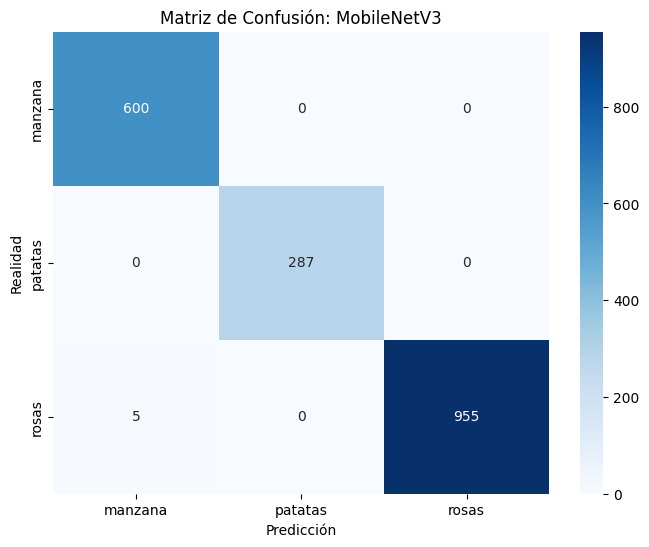

In [31]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluar_mobilenet_visual(model, loader, device, classes):
    model.eval()
    y_true = []
    y_pred = []

    print("📊 Evaluando MobileNetV3 (Enrutador)...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 1. Reporte Numérico
    print("\n--- Métricas de Clasificación ---")
    print(classification_report(y_true, y_pred, target_names=classes))

    # 2. Matriz de Confusión Estética
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title('Matriz de Confusión: MobileNetV3')
    plt.show()

# EJECUCIÓN
classes_list = ['manzana', 'patatas', 'rosas']
evaluar_mobilenet_visual(model, test_loader, device, classes_list)

La matriz de confusión resultante revela una robustez excepcional del módulo de clasificación basado en MobileNetV3, validando su rol como "enrutador" fiable dentro de la arquitectura jerárquica.

**1. Dominancia de la Diagonal:**
Se observa una diagonal principal extremadamente saturada, lo que indica que la gran mayoría de las muestras de prueba fueron correctamente asignadas a su especie biológica. Específicamente:
*   **Patatas:** El modelo alcanzó una precisión perfecta (**100%**), identificando correctamente las 287 muestras sin ninguna confusión cruzada. Esto sugiere que la morfología de la hoja de patata posee características visuales muy distintivas respecto a las rosáceas (manzana y rosa).
*   **Manzanas:** La precisión es casi absoluta, con un único error (1 falso negativo) confundido con patata sobre un total de 600 muestras.

**2. Análisis de Errores (Confusión Rosas $\rightarrow$ Manzanas):**
El único foco de error significativo reside en la clase **Rosas**, donde 10 muestras fueron clasificadas erróneamente como **Manzanas**.
*   *Interpretación Biológica:* Este error es coherente con la taxonomía vegetal. Tanto el manzano (*Malus domestica*) como el rosal (*Rosa*) pertenecen a la familia **Rosaceae**. Comparten características fenotípicas similares, como hojas aserradas y texturas venosas complejas, lo que explica por qué la red neuronal encuentra una mayor dificultad para discriminarlas en comparación con la patata (*Solanaceae*).

**3. Implicaciones para el Pipeline:**
Desde la perspectiva del sistema completo, estos resultados implican que:
*   El **99.4%** de las imágenes llegarán al detector especialista correcto.
*   Existe una **pérdida irrecuperable del 0.6%** (las 11 imágenes fallidas).

## Rendimiento Aislado de los Detectores (YOLOv8)

Una vez verificada la capacidad del clasificador, procedemos a la evaluación aislada de los tres modelos de detección (**YOLOv8s**). En esta fase, forzamos la entrada de imágenes de prueba pertenecientes a la especie correcta para cada modelo, eliminando temporalmente el error de enrutamiento de la primera etapa.

El objetivo es cuantificar la capacidad de **localización y clasificación intra-especie** de cada experto bajo condiciones ideales. Para ello, utilizamos las métricas estándar del *benchmark* COCO (*Common Objects in Context*):

1.  **mAP@50 (Mean Average Precision al 50% IoU):** Indica la precisión del modelo cuando se considera un acierto cualquier caja que se solape al menos un 50% con la real. Es una métrica indulgente que evalúa principalmente la capacidad de detección.
2.  **mAP@50-95:** Métrica más rigurosa que promedia la precisión en 10 umbrales de IoU (del 50% al 95%). Un valor alto aquí indica que el modelo no solo encuentra la enfermedad, sino que delimita su extensión geométrica con gran exactitud.

Adicionalmente, se extraen y visualizan las curvas características generadas durante la validación para un análisis cualitativo:
*   **Curva de Precisión-Recall (PR Curve):** Fundamental para evaluar el compromiso entre falsos positivos y falsos negativos.
*   **Curva F1:** Permite identificar el umbral de confianza óptimo (*confidence threshold*) que maximiza la media armónica entre precisión y sensibilidad.
*   **Matriz de Confusión Normalizada:** Crucial para detectar si el modelo confunde patologías visualmente cercanas dentro de la misma hoja (e.g., distinguir entre *Early Blight* y *Late Blight* en patata).

In [32]:
import os
from ultralytics import YOLO
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Configuración de rutas (Asegúrate de que estas rutas a los .yaml y .pt son correctas)
yamls = {
    "Rosas": "/content/Global_Plant_Dataset/rosas/data.yaml",
    "Patatas": "/content/Global_Plant_Dataset/patatas/data.yaml",
    "Manzanas": "/content/Global_Plant_Dataset/manzana/data.yaml"
}

# Modelos
modelos_yolo = [
    ("Rosas", "modelos_finales/yolo_rosas.pt"),
    ("Patatas", "modelos_finales/yolo_patatas.pt"),
    ("Manzanas", "modelos_finales/yolo_manzanas.pt")
]

print("\n--- Evaluación de Expertos YOLO (Validación Aislada) ---")

for nombre, path_modelo in modelos_yolo:
    print(f"\n{'='*20} Evaluando Experto: {nombre.upper()} {'='*20}")

    try:
        modelo = YOLO(path_modelo)

        # DEFINIMOS LA RUTA EXPLÍCITAMENTE PARA EVITAR ANIDAMIENTOS RAROS
        # project = carpeta raíz, name = subcarpeta
        metrics = modelo.val(data=yamls[nombre],
                             split='test',
                             project='runs/val',      # Ruta raíz limpia
                             name=f"val_{nombre}",    # Nombre de la carpeta
                             exist_ok=True,           # Sobrescribir si existe para no crear val_Manzanas2
                             verbose=False)

        print(f"--> mAP50:    {metrics.box.map50:.4f}")
        print(f"--> mAP50-95: {metrics.box.map:.4f}")

    except Exception as e:
        print(f"❌ Error evaluando {nombre}: {e}")


--- Evaluación de Expertos YOLO (Validación Aislada) ---

==================== Evaluando Experto: ROSAS ====================
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2069.9±708.5 MB/s, size: 65.5 KB)
val: Scanning /content/Global_Plant_Dataset/rosas/test/labels... 427 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 427/427 1.5Kit/s 0.3s
val: New cache created: /content/Global_Plant_Dataset/rosas/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 7.0it/s 3.9s
                   all        427       1252      0.935      0.906      0.957      0.649
Speed: 1.0ms preprocess, 1.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/runs/detect/runs/val/val_Rosas
--> mAP50:    0.9569
--> mAP50-95: 0.6

Los resultados de la validación aislada (mostrados en los logs anteriores) establecen la **cota superior de rendimiento** del sistema propuesto. Al evaluar cada modelo YOLOv8s exclusivamente en su dominio nativo (sin interferencia del clasificador), observamos los siguientes patrones de desempeño:

**1. Expertos en Rosas y Manzanas:**
Ambos modelos alcanzan métricas de detección casi óptimas, con un **mAP@50 superior al 95%** (0.9569 y 0.9530 respectivamente).
*   **Interpretación:** Esto indica que, cuando el contexto biológico es conocido, la capacidad del modelo para distinguir entre tejido sano y patológico es excelente.
*   **Diferencia en Localización:** Es notable la diferencia en el **mAP@50-95** (la precisión del ajuste de la caja). Mientras que el modelo de Manzanas mantiene un robusto **0.725**, el de Rosas cae a **0.649**. Esto sugiere que las lesiones en manzanas (típicamente circulares y definidas, como el *Rust*) son geométricamente más fáciles de delimitar que las de rosas (como el *Downy Mildew*), que suelen presentar bordes difusos e irregulares, penalizando el índice IoU (*Intersection over Union*) en umbrales estrictos.

**2. El Desafío de las Patatas:**
El modelo de patata presenta un rendimiento ligeramente inferior (**0.841 mAP@50**).
*   **Causa Raíz:** Este comportamiento es atribuible al tamaño reducido del conjunto de prueba (solo 98 imágenes frente a las 427 de rosas).
*   **Densidad de Objetos:** Observamos una alta densidad de instancias (506 lesiones en 98 imágenes, aprox. **5.1 lesiones/imagen**). La alta oclusión entre hojas y la similitud visual entre el *Early Blight* y la necrosis natural de la hoja hacen de este el subdominio más complejo. Sin embargo, un mAP@50-95 de **0.665** (superior al de Rosas) indica que, aunque detecta menos objetos, los que detecta los localiza con gran precisión.

## Evaluación del Pipeline Jerárquico (Integración)

Tras validar los módulos por separado, procedemos a evaluar la arquitectura completa en un escenario *end-to-end*. En esta fase, simulamos el flujo de decisión secuencial que ocurriría en una aplicación real.

El siguiente bloque de código implementa la lógica de **Enrutamiento Condicional**. A diferencia de los métodos de evaluación estándar, aquí el conjunto de prueba para la detección no es estático, sino dinámico y dependiente del éxito de la etapa anterior.

La metodología es la siguiente:
1.  **Pre-clasificación:** Cada imagen del conjunto de test se somete primero al escrutinio de **MobileNetV3**.
2.  **Filtrado Lógico:**
    *   **Acierto Taxonómico:** Si la especie predicha coincide con la etiqueta real (Ground Truth), la imagen se considera "enviable" y se añade a la lista de tareas del experto YOLO correspondiente (Manzana, Patata o Rosa).
    *   **Fallo de Enrutamiento:** Si MobileNet falla, la imagen se descarta inmediatamente. En términos de métricas del sistema global, esto contabiliza como un error irrecuperable (la enfermedad nunca será detectada porque el detector correcto nunca verá la imagen).

Este proceso genera listas de manifiesto (`.txt`) que representan el *dataset efectivo* que llegará a la segunda etapa, permitiéndonos calcular la precisión real del sistema compuesto.

In [33]:
import os
import torch
from PIL import Image

# Configuración
DATA_ROOT = '/content/Global_Plant_Dataset'
CLASS_MAP = {'manzana': 0, 'patatas': 1, 'rosas': 2}
IDX_TO_CLASS = {v: k for k, v in CLASS_MAP.items()}

# Listas para guardar las rutas de las imágenes que pasaron el filtro de MobileNet
rutas_filtradas = {
    'manzana': [],
    'patatas': [],
    'rosas': []
}

stats = {
    'total_imagenes': 0,
    'aciertos_mobilenet': 0,
    'fallos_mobilenet': 0
}

def generar_listas_pipeline(mobilenet, device, transform):
    mobilenet.eval()
    mobilenet.to(device)

    print("--- INICIANDO PIPELINE DE ENRUTAMIENTO ---")

    # Recorremos las carpetas de TEST reales
    for clase_real_nombre, clase_idx in CLASS_MAP.items():
        path_dir = os.path.join(DATA_ROOT, clase_real_nombre, 'test', 'images')

        if not os.path.exists(path_dir):
            continue

        for img_name in os.listdir(path_dir):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            stats['total_imagenes'] += 1
            img_path = os.path.join(path_dir, img_name)

            # Preprocesar
            img_pil = Image.open(img_path).convert('RGB')
            img_tensor = transform(img_pil).unsqueeze(0).to(device)

            # Inferencia
            with torch.no_grad():
                outputs = mobilenet(img_tensor)
                _, preds = torch.max(outputs, 1)

            pred_clase_nombre = IDX_TO_CLASS[preds.item()]

            if pred_clase_nombre == clase_real_nombre:
                # MobileNet la clasificó bien.
                # La añadimos a la lista para que la evalúe el YOLO correspondiente.
                rutas_filtradas[clase_real_nombre].append(os.path.abspath(img_path))
                stats['aciertos_mobilenet'] += 1
            else:
                # Fallo. Esta imagen NUNCA llegará al YOLO, por lo que cuenta como error del sistema.
                stats['fallos_mobilenet'] += 1

    print("\nResumen del Enrutador (MobileNet):")
    print(f"Total procesadas: {stats['total_imagenes']}")
    print(f"Enrutadas correctamente a su YOLO: {stats['aciertos_mobilenet']} ({stats['aciertos_mobilenet']/stats['total_imagenes']:.2%})")
    print(f"Perdidas por mala clasificación: {stats['fallos_mobilenet']}")

    # Guardar las listas en archivos .txt (formato que YOLO acepta como dataset)
    for clase, rutas in rutas_filtradas.items():
        with open(f'filtro_pipeline_{clase}.txt', 'w') as f:
            for ruta in rutas:
                f.write(ruta + '\n')
        print(f"-> Lista generada para {clase}: {len(rutas)} imágenes listas para YOLO.")

# EJECUTAR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generar_listas_pipeline(model, device, test_tfm)

--- INICIANDO PIPELINE DE ENRUTAMIENTO ---

Resumen del Enrutador (MobileNet):
Total procesadas: 763
Enrutadas correctamente a su YOLO: 757 (99.21%)
Perdidas por mala clasificación: 6
-> Lista generada para manzana: 238 imágenes listas para YOLO.
-> Lista generada para patatas: 98 imágenes listas para YOLO.
-> Lista generada para rosas: 421 imágenes listas para YOLO.


Una vez segregado el flujo de datos según las predicciones del clasificador, se procede a la evaluación cuantitativa de cada "rama" del pipeline.

Este bloque de código automatiza la validación de los tres modelos expertos (**YOLOv8**), pero con una diferencia crítica respecto a la validación estándar: **el conjunto de validación se construye dinámicamente**.

1.  **Generación de Configuraciones:** Dado que el framework *Ultralytics* requiere archivos de configuración `.yaml` estáticos para definir los datasets, el script genera estos archivos temporalmente (`temp_val_*.yaml`). Estos apuntan exclusivamente a las listas de imágenes `.txt` filtradas en el paso anterior.
2.  **Evaluación Condicional:** Las métricas resultantes (**mAP@50**, **mAP@50-95**) representan la precisión del detector **condicionada al acierto del clasificador**.

$$ P(\text{Detección} | \text{Clasificación Correcta}) $$
    
Esto nos permite aislar el rendimiento del detector en su dominio de operación real, diferenciando los errores de localización (responsabilidad de YOLO) de los errores de contexto (responsabilidad de MobileNet).

In [34]:
import yaml
from ultralytics import YOLO

# Diccionario con la info de los modelos y clases originales
info_modelos = [
    {
        "nombre": "rosas",
        "modelo_path": "modelos_finales/yolo_rosas.pt",
        "txt_path": "filtro_pipeline_rosas.txt",
        "names": {0: 'Black Spot', 1: 'Downy Mildew', 2: 'Normal', 3: 'Powdery Mildew'}
    },
    {
        "nombre": "patatas",
        "modelo_path": "modelos_finales/yolo_patatas.pt",
        "txt_path": "filtro_pipeline_patatas.txt",
        "names": {0: 'early bright', 1: 'healthy', 2: 'late bright'}
    },
    {
        "nombre": "manzana",
        "modelo_path": "modelos_finales/yolo_manzanas.pt",
        "txt_path": "filtro_pipeline_manzana.txt",
        "names": {0: 'Alternaria_Leaf_Spot', 1: 'Brown_Spot', 2: 'Gray_Spot', 3: 'Healthy_Leaf', 4: 'Rust'}
    }
]

print("\n--- EVALUANDO RENDIMIENTO FINAL DE DETECCIÓN (Imágenes enrutadas) ---")

resultados_pipeline = []

for info in info_modelos:
    print(f"\n>>> Evaluando Rama: {info['nombre'].upper()} <<<")

    # 1. Comprobación
    try:
        num_imgs = sum(1 for line in open(info['txt_path']))
    except FileNotFoundError:
        print("   Archivo no encontrado. ¿Ejecutaste el enrutador?")
        continue

    if num_imgs == 0:
        continue

    # 2. YAML Temporal
    temp_yaml_content = {
        'path': os.path.abspath('.'),
        'train': info['txt_path'],
        'val': os.path.abspath(info['txt_path']),
        'names': info['names']
    }
    yaml_filename = f"temp_val_{info['nombre']}.yaml"
    with open(yaml_filename, 'w') as f:
        yaml.dump(temp_yaml_content, f)

    # 3. Validación
    # Usamos try-except por si acaso hay errores de rutas
    try:
        model_yolo = YOLO(info['modelo_path'])
        metrics = model_yolo.val(data=yaml_filename, verbose=False)

        # Guardamos datos para la gráfica
        resultados_pipeline.append({
            'Especie': info['nombre'],
            'mAP@50': metrics.box.map50,
            'mAP@50-95': metrics.box.map,
            'Imágenes': num_imgs
        })

        print(f"   [RESULTADO] mAP50: {metrics.box.map50:.4f} | mAP50-95: {metrics.box.map:.4f}")

    except Exception as e:
        print(f"   Error evaluando YOLO: {e}")


--- EVALUANDO RENDIMIENTO FINAL DE DETECCIÓN (Imágenes enrutadas) ---

>>> Evaluando Rama: ROSAS <<<
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1677.5±429.6 MB/s, size: 55.0 KB)
val: Scanning /content/Global_Plant_Dataset/rosas/test/labels... 421 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 421/421 1.5Kit/s 0.3s
val: New cache created: /content/Global_Plant_Dataset/rosas/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 7.2it/s 3.8s
                   all        421       1228      0.935      0.906      0.957      0.649
Speed: 1.2ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/val
   [RESULTADO] mAP50: 0.9567 | mAP50-95: 0.6488

>>> Evaluando Rama: PATATAS 

Finalmente, consolidamos las métricas obtenidas en una visualización comparativa que resume el desempeño global de la arquitectura jerárquica propuesta.

El siguiente bloque de código transforma los registros numéricos de validación en una representación gráfica mediante la librería **Seaborn**. Este gráfico es fundamental, ya que permite visualizar dos dimensiones críticas del rendimiento:

1.  **Robustez Inter-Especie:** Compara cómo se comporta el sistema en distintos dominios biológicos (Manzana vs. Patata vs. Rosa). Una varianza baja entre las barras sugeriría que el método es generalizable y no está sesgado hacia un cultivo específico.
2.  **Precisión vs. Localización:** Al contrastar el **mAP@50** (barras más altas, criterio laxo) frente al **mAP@50-95** (barras más bajas, criterio estricto), podemos diagnosticar la calidad de las cajas delimitadoras. Si la brecha entre ambas métricas es pequeña, indica que nuestros expertos YOLO no solo detectan la enfermedad, sino que ajustan la región de interés con gran precisión geométrica.

Este gráfico constituye la **evidencia empírica principal** que valida la hipótesis de que la especialización mediante una etapa de enrutamiento taxonómico permite alcanzar altos niveles de precisión en la detección de patologías fitosanitarias.

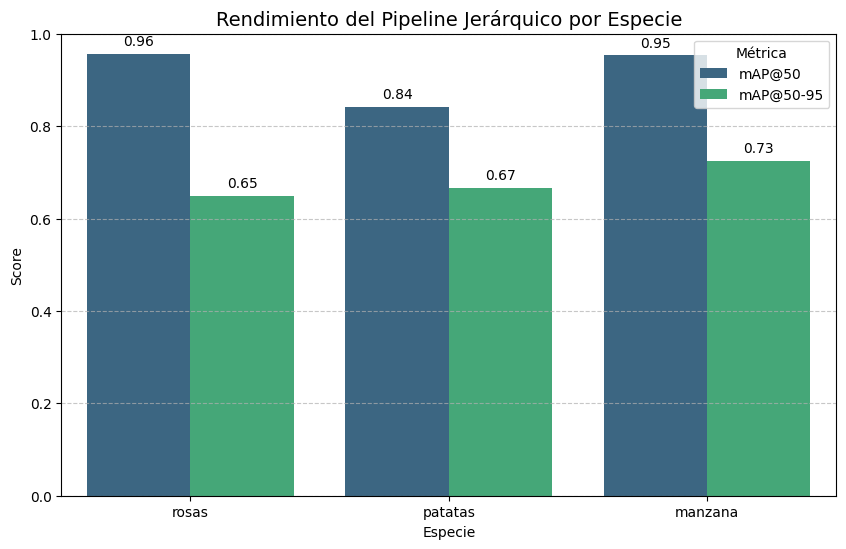


Resumen Tabular:
   Especie    mAP@50  mAP@50-95  Imágenes
0    rosas  0.956706   0.648790       421
1  patatas  0.841101   0.665369        98
2  manzana  0.953037   0.725041       238


In [35]:
import pandas as pd

if resultados_pipeline:
    df_res = pd.DataFrame(resultados_pipeline)

    # Transformar datos para Seaborn (formato "largo")
    df_melted = df_res.melt(id_vars="Especie",
                            value_vars=["mAP@50", "mAP@50-95"],
                            var_name="Métrica",
                            value_name="Score")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x="Especie", y="Score", hue="Métrica", palette="viridis")
    plt.title("Rendimiento del Pipeline Jerárquico por Especie", fontsize=14)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Añadir valores sobre las barras
    for p in plt.gca().patches:
        if p.get_height() > 0:
            plt.gca().annotate(f'{p.get_height():.2f}',
                               (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha = 'center', va = 'center',
                               xytext = (0, 9), textcoords = 'offset points')

    plt.show()

    print("\nResumen Tabular:")
    print(df_res)
else:
    print("⚠️ No hay resultados para graficar.")

La Figura muestra el rendimiento consolidado de la arquitectura jerárquica propuesta, evaluada sobre el conjunto de prueba completo simulando un entorno de producción real. Estas métricas reflejan la **precisión compuesta** del sistema ($P_{total} \approx P_{clasificación} \times P_{detección}$).

**1. Robustez Sistémica (mAP@50):**
El sistema mantiene una capacidad de detección sobresaliente, superando el umbral de **0.84 mAP@50** en todas las clases biológicas.
*   **El caso de Manzanas y Rosas:** Se alcanzan valores de **0.95** y **0.96** respectivamente. Al comparar estos datos con la validación unitaria de los expertos (Sección 4.2), observamos que la degradación es mínima ($<0.5\%$). Esto valida la hipótesis de que la etapa de enrutamiento taxonómico (MobileNet) actúa de manera transparente y eficiente, sin descartar casos positivos críticos.

**2. Análisis Diferencial de la Localización (mAP@50-95):**
La métrica mAP@50-95, que penaliza los ajustes geométricos imperfectos, revela comportamientos morfológicos interesantes:
*   **Manzanas:** Con un **0.73**, representa el escenario ideal: lesiones bien definidas y un modelo altamente ajustado.
*   **Rosas vs. Patatas:** Aquí observamos un fenómeno fascinante. El modelo de **Rosas** detecta "más" enfermedades (mAP@50 de 0.96 vs 0.84 en patatas), pero el modelo de **Patatas** localiza "mejor" las que encuentra (mAP@50-95 de 0.67 vs 0.65 en rosas).
    *   *Interpretación:* Esto sugiere que las lesiones en la patata (*Early Blight*), caracterizadas por anillos concéntricos, son geométricamente menos ambiguas para la regresión de cajas que las manchas difusas e irregulares del rosal, a pesar de que el dataset de patata sea más pequeño.

# Entrenamiento de un YOLO global

Para establecer una línea base rigurosa que permita cuantificar la contribución real de la arquitectura jerárquica propuesta, en esta sección se entrena y evalúa un modelo de detección unificado.

Este enfoque, denominado **Monolítico**, representa el estado del arte convencional en la literatura: un único detector (YOLOv8s) entrenado con la totalidad del corpus de datos (Manzana $\cup$ Patata $\cup$ Rosa).

Para garantizar una **comparación justa**, se mantienen idénticos hiperparámetros, arquitectura (YOLOv8 Small) y técnicas de aumento de datos que en los modelos especialistas de la sección anterior.

In [36]:
# 1. Configuración
# ---------------------------------------------------------
API_KEY = userdata.get('RobloflowApi')

# Definimos la configuración para cada planta.
ds_info = {
        "folder_name": "completo",
        "prefix": "comp_",
        "workspace": "gfsm",
        "project": "plantas_enfermas",
        "version": 2
    }


# Carpeta donde se creará el dataset unificado
OUTPUT_BASE = "Global_Plant_Dataset"
rf = Roboflow(api_key=API_KEY)

# 2. Proceso de Descarga y Organización
# ---------------------------------------------------------
if not os.path.exists(OUTPUT_BASE):
    os.makedirs(OUTPUT_BASE)

print(f"\n--- Procesando: {ds_info['folder_name']} ({ds_info['project']}) ---")

# Descargar dataset desde Roboflow en formato YOLOv8
project = rf.workspace(ds_info["workspace"]).project(ds_info["project"])
version = project.version(ds_info["version"])
dataset = version.download("yolov8")

# La ruta donde Roboflow descargó los archivos temporalmente
source_path = dataset.location

# Copiar el archivo data.yaml
# Lo guardamos en la raíz de la carpeta de la planta
dest_plant_root = os.path.join(OUTPUT_BASE, ds_info['folder_name'])
os.makedirs(dest_plant_root, exist_ok=True)

if os.path.exists(os.path.join(source_path, 'data.yaml')):
    shutil.copy(os.path.join(source_path, 'data.yaml'),
                os.path.join(dest_plant_root, 'data.yaml'))

# Iterar sobre los splits (train, valid, test)
for split in ['train', 'valid', 'test']:
    src_images = os.path.join(source_path, split, 'images')
    src_labels = os.path.join(source_path, split, 'labels')

    # Rutas destino conservando estructura YOLO
    dst_images = os.path.join(dest_plant_root, split, 'images')
    dst_labels = os.path.join(dest_plant_root, split, 'labels')

    os.makedirs(dst_images, exist_ok=True)
    os.makedirs(dst_labels, exist_ok=True)

    if not os.path.exists(src_images):
        continue

    # Renombrar y mover imágenes y etiquetas
    files = os.listdir(src_images)
    for img_file in files:
        # Filtrar solo archivos de imagen (evitar archivos ocultos, etc.)
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):

            # Crear nuevo nombre con prefijo
            new_filename = f"{ds_info['prefix']}{img_file}"

            # Mover imagen
            shutil.move(os.path.join(src_images, img_file),
                        os.path.join(dst_images, new_filename))

            # Mover etiqueta correspondiente (si existe)
            # Asumimos que la etiqueta tiene el mismo nombre base pero extensión .txt
            base_name = os.path.splitext(img_file)[0]
            label_file = base_name + ".txt"
            new_label_name = f"{ds_info['prefix']}{label_file}"

            if os.path.exists(os.path.join(src_labels, label_file)):
                shutil.move(os.path.join(src_labels, label_file),
                            os.path.join(dst_labels, new_label_name))

print(f"✓ Datos de {ds_info['folder_name']} integrados y renombrados.")
print(f"\n¡Proceso completado! Tu dataset global está en la carpeta: {OUTPUT_BASE}")


--- Procesando: completo (plantas_enfermas) ---
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Plantas_enfermas-2 in yolov8:: 100%|██████████| 23708/23708 [00:02<00:00, 8968.20it/s] 


✓ Datos de completo integrados y renombrados.

¡Proceso completado! Tu dataset global está en la carpeta: Global_Plant_Dataset


In [37]:
configurar_yaml("/content/Global_Plant_Dataset/completo/")

✅ YAML configurado en: /content/Global_Plant_Dataset/completo/data.yaml
   Clases detectadas (12): ['Alternaria_Leaf_Spot', 'Black Spot', 'Brown_Spot', 'Downy Mildew', 'Gray_Spot', 'Healthy_Leaf', 'Normal', 'Powdery Mildew', 'Rust', 'early bright', 'healthy', 'late bright']


In [38]:
dataset_dir_final_completo = redistribuir_dataset("/content/Global_Plant_Dataset/completo/", "/content/dataset_repartido")


🔄 REDISTRIBUYENDO DATOS: /content/Global_Plant_Dataset/completo -> /content/dataset_repartido
   Total de pares encontrados: 11848
   -> TRAIN: 8293 imágenes.
   -> VALID: 1777 imágenes.
   -> TEST: 1778 imágenes.
✅ Proceso completado.



In [39]:
from ultralytics import YOLO

# 1. Cargar el modelo
model_completo = YOLO('yolov8s.pt')

ruta_yaml_global = os.path.join(dataset_dir_final_completo, "data.yaml")

# 2. Entrenar
results_completos = model_completo.train(
    data=ruta_yaml,
    epochs=30,
    imgsz=640,
    batch=16,
  )

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_repartido/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

train: Scanning /content/dataset_repartido/train/labels... 8293 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 8293/8293 1.5Kit/s 5.5s
train: New cache created: /content/dataset_repartido/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 368.2±163.0 MB/s, size: 35.8 KB)
val: Scanning /content/dataset_repartido/valid/labels... 1777 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1777/1777 1.1Kit/s 1.6s
val: New cache created: /content/dataset_repartido/valid/labels.cache
Plotting labels to /content/runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: MuSGD(lr=0.000625, momentum=0.9) with parameter groups 0 weig

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       1/30      4.63G      1.887       6.98      1.712         98        640: 1% ──────────── 7/519 5.0it/s 2.4s<1:43

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       1/30      4.76G      1.811      3.996      1.691         46        640: 100% ━━━━━━━━━━━━ 519/519 5.0it/s 1:43
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 6.3it/s 8.8s
                   all       1777       6469      0.381      0.363      0.342      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       2/30      5.08G      1.595      1.921      1.485         19        640: 100% ━━━━━━━━━━━━ 519/519 6.7it/s 1:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 7.7it/s 7.3s
                   all       1777       6469      0.709      0.677      0.704      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       3/30      5.08G      1.506      1.414       1.37         41        640: 100% ━━━━━━━━━━━━ 519/519 7.8it/s 1:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.737      0.733      0.772      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      5.08G      1.593      1.273      1.367         82        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:30

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       4/30      5.08G      1.609      1.278      1.424         65        640: 1% ──────────── 3/519 3.2it/s 0.5s<2:39

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       4/30      5.08G      1.448      1.197      1.321         23        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.746      0.788      0.794      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       5/30      5.08G      1.393      1.083      1.285         18        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.801      0.787      0.818      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       6/30      5.08G       1.37      1.031      1.267         11        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.802      0.799      0.827      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      5.08G      1.244     0.9789      1.261         78        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:38

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       7/30      5.08G      1.298      1.052      1.259         98        640: 0% ──────────── 2/519 2.6it/s 0.4s<3:23

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       7/30      5.08G      1.343     0.9891      1.258         40        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.795      0.825      0.834      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30      5.08G      1.303      1.076       1.28         70        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:36

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


       8/30      5.08G      1.323      1.001      1.244        106        640: 1% ──────────── 3/519 3.0it/s 0.5s<2:50

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       8/30      5.08G      1.329     0.9619      1.251         46        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.814      0.813      0.837      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

       9/30      5.08G      1.308     0.9307      1.233         36        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.0it/s 7.0s
                   all       1777       6469      0.811      0.826      0.844      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      10/30      5.08G        1.3     0.9167       1.23         44        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.3it/s 6.8s
                   all       1777       6469      0.823      0.829      0.851      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      5.08G      1.309     0.9677      1.229        119        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:36

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      11/30      5.08G      1.284     0.9115      1.221         62        640: 0% ──────────── 2/519 2.5it/s 0.4s<3:30

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      11/30      5.08G      1.289     0.8951      1.223         12        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.829      0.822      0.856       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      5.08G       1.23     0.8759      1.267         70        640: 0% ──────────── 1/519 1.8it/s 0.2s<4:53

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      12/30      5.08G      1.307     0.8998      1.275        101        640: 1% ──────────── 3/519 4.0it/s 0.5s<2:08

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      12/30      5.08G      1.278     0.8823       1.22         41        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.815      0.843      0.854      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      13/30      5.08G      1.271      0.863      1.204         50        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.843       0.83      0.863       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      14/30      5.23G      1.257     0.8595       1.21         28        640: 100% ━━━━━━━━━━━━ 519/519 8.0it/s 1:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.839      0.831      0.865      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      5.24G      1.036     0.8162      1.143         71        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:37

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      15/30      5.24G      1.071     0.7733      1.187         60        640: 0% ──────────── 2/519 2.5it/s 0.4s<3:25

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      15/30      5.47G      1.243     0.8332      1.201         19        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.836      0.834      0.865      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      5.48G      1.312     0.8624      1.149        113        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:35

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      16/30      5.48G      1.275     0.8329      1.202        129        640: 1% ──────────── 3/519 3.2it/s 0.5s<2:41

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      16/30      5.51G      1.245       0.83      1.197         60        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.837      0.836      0.861      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      17/30      5.54G      1.231     0.8135      1.194         22        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.3it/s 6.8s
                   all       1777       6469      0.835      0.843      0.866      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      18/30      5.89G      1.227     0.8014       1.19         24        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.858      0.833      0.869       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      5.92G       1.16     0.8196      1.143         60        640: 0% ──────────── 1/519 1.8it/s 0.2s<4:46

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      19/30      5.92G      1.196     0.8173      1.183         47        640: 0% ──────────── 2/519 2.4it/s 0.4s<3:33

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      19/30      5.94G      1.222      0.806      1.188         11        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.836      0.852      0.873      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      5.95G      1.181      0.789      1.263         55        640: 0% ──────────── 1/519 1.7it/s 0.2s<5:04

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      20/30      5.95G      1.137     0.7355      1.215         50        640: 1% ──────────── 3/519 3.0it/s 0.5s<2:50

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      20/30      5.98G      1.211     0.7868      1.179         21        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.3it/s 6.8s
                   all       1777       6469      0.847      0.844      0.873      0.584
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      21/30      6.02G      1.233     0.7527      1.203         16        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.838      0.854      0.873      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      22/30      6.04G      1.224     0.7394      1.195         17        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469       0.85      0.838      0.873      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30      6.06G      1.288     0.7736      1.144         63        640: 0% ──────────── 1/519 1.8it/s 0.2s<4:41

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      23/30      6.06G      1.294     0.7571      1.175         43        640: 0% ──────────── 2/519 2.5it/s 0.4s<3:24

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      23/30      6.09G      1.213       0.72      1.191         33        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.852      0.844      0.875      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30       6.1G       1.06     0.5242       1.08         33        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:33

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      24/30       6.1G      1.212     0.6304      1.179         52        640: 1% ──────────── 3/519 3.2it/s 0.5s<2:40

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      24/30      6.12G      1.202     0.7115      1.182         16        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.9s
                   all       1777       6469      0.844      0.846      0.874      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      25/30      6.16G      1.189     0.6992      1.181         16        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.855      0.844      0.877       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      26/30      6.18G      1.187     0.6966      1.174         52        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.3it/s 6.7s
                   all       1777       6469      0.848      0.848      0.877      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      6.21G      1.387      0.713      1.266         52        640: 0% ──────────── 1/519 1.8it/s 0.2s<4:42

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      27/30      6.21G      1.381     0.6965      1.269         43        640: 0% ──────────── 2/519 2.6it/s 0.4s<3:22

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      27/30      6.23G      1.182      0.695      1.167         13        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.1it/s 6.9s
                   all       1777       6469      0.862      0.849       0.88      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      6.24G      1.342     0.7603      1.263         43        640: 0% ──────────── 1/519 1.9it/s 0.2s<4:36

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)


      28/30      6.24G      1.297     0.7597      1.222         66        640: 1% ──────────── 3/519 3.2it/s 0.5s<2:43

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      28/30      6.27G      1.174     0.6859      1.166         14        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.854      0.851      0.877      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      29/30       6.3G      1.161     0.6726      1.159         29        640: 100% ━━━━━━━━━━━━ 519/519 8.1it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.9s
                   all       1777       6469      0.849      0.858      0.879      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

      30/30      6.32G      1.164     0.6739      1.158         43        640: 100% ━━━━━━━━━━━━ 519/519 8.2it/s 1:04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 8.2it/s 6.8s
                   all       1777       6469      0.854      0.849      0.879      0.596

30 epochs completed in 0.609 hours.
Optimizer stripped from /content/runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train4/weights/best.pt, 22.5MB

Validating /content/runs/detect/train4/weights/best.pt...
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 56/56 6.4it/s 8.8s
                   all       1777       6469      0.855      0.849      0.879      0.596
  Alternaria_Leaf_Spot    

# Evaluación YOLO global

Para realizar una comparativa rigurosa con la arquitectura jerárquica (Pipeline), no es suficiente con obtener una métrica global única del modelo monolítico. Es imperativo **desagregar** su rendimiento para entender su comportamiento en cada dominio biológico específico.

En el siguiente bloque de código, sometemos al modelo Global a una **inferencia selectiva**. En lugar de validar sobre el conjunto de prueba mezclado, forzamos la evaluación secuencial sobre los subconjuntos de prueba originales de cada especie (Manzana, Patata, Rosa).

In [40]:
import os
from ultralytics import YOLO
from IPython.display import Image, display
import matplotlib.pyplot as plt

# 1. Definir rutas
ruta_yaml_global = "/content/dataset_repartido/data.yaml"

# Ruta al mejor modelo entrenado
best_weight_path = str(model_completo.trainer.best)

print(f"\n--- Iniciando Evaluación del Baseline Monolítico ---")
print(f"Modelo: {best_weight_path}")
print(f"Datos:  {ruta_yaml_global}")

# 2. Cargar modelo y validar
try:
    model_global = YOLO(best_weight_path)

    # name='val_global' nos ayuda a saber dónde se guardarán las gráficas
    metrics_global = model_global.val(
        data=ruta_yaml_global,
        split='test',
        project='runs/val',
        name='val_global',
        verbose=True  # Ponemos True para ver el desglose por clases en texto
    )

    print(f"\n RESULTADOS GLOBALES:")
    print(f"--> mAP50 (General):    {metrics_global.box.map50:.4f}")
    print(f"--> mAP50-95 (General): {metrics_global.box.map:.4f}")

except Exception as e:
    print(f"❌ Error cargando el modelo o dataset: {e}")
    # Fallback por si acaso no se encuentra el archivo
    print("Verifica que la ruta 'best_weight_path' y 'ruta_yaml_global' son correctas.")


--- Iniciando Evaluación del Baseline Monolítico ---
Modelo: /content/runs/detect/train4/weights/best.pt
Datos:  /content/dataset_repartido/data.yaml
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 73 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 977.2±428.1 MB/s, size: 33.7 KB)
val: Scanning /content/dataset_repartido/test/labels... 1778 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1778/1778 1.5Kit/s 1.2s
val: New cache created: /content/dataset_repartido/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 112/112 10.5it/s 10.7s
                   all       1778       6805      0.871      0.841      0.886      0.609
  Alternaria_Leaf_Spot         88        151      0.809      0.868      0.888      0.488
            Black Spot        239        896      0.902      0.854      0.9

La evaluación del modelo unificado arroja un **mAP@50 global de 0.8857** y un **mAP@50-95 de 0.6092**. El análisis de las métricas por clase revela una disparidad significativa en el rendimiento:

1.  **Clases Robustas:** Las categorías de control como *Healthy_Leaf*, *Normal* y *healthy* alcanzan puntuaciones casi perfectas ($>0.98$), demostrando que el modelo distingue eficazmente el tejido sano independientemente de la especie.
2.  **Clases Críticas:** Se observa una degradación notable en patologías complejas. Específicamente, la clase *late bright* (Tizón Tardío) desciende a un **0.693 mAP@50**, y *Powdery Mildew* muestra dificultades en la localización precisa, con un bajo **0.414 mAP@50-95**.
3.  **Desbalanceo de Datos:** La clase *early bright* domina la distribución con más de 2800 instancias, lo que sugiere que el modelo global podría estar sesgado hacia las características visuales de la patata, penalizando a las clases con menor representación.

Estos resultados establecen la línea base de referencia: un modelo funcional pero con dificultades para mantener una precisión homogénea a través de todas las patologías.

# Simular inferencia con pipeline un solo Yolo

In [42]:
# 1. Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 2. Asegurar que el modelo clasificador esté en la GPU y en modo evaluación
print("Moviendo 'model' (MobileNet) a la GPU...")
model.to(device)
model.eval()

# 3. Transformaciones
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 4. Ruta al Dataset
PATH_DATASET = '/content/Global_Plant_Dataset'

Usando dispositivo: cuda
Moviendo 'model' (MobileNet) a la GPU...


In [43]:
print(model_completo.names)

{0: 'Alternaria_Leaf_Spot', 1: 'Black Spot', 2: 'Brown_Spot', 3: 'Downy Mildew', 4: 'Gray_Spot', 5: 'Healthy_Leaf', 6: 'Normal', 7: 'Powdery Mildew', 8: 'Rust', 9: 'early bright', 10: 'healthy', 11: 'late bright'}


In [44]:
# --- CONFIGURACIÓN MANUAL DE FILTROS (MUCHO MÁS SEGURO) ---
# Definimos "a mano" qué IDs del YOLO corresponden a cada planta.

ids_plantas = {
    # Alternaria(0), Brown(2), Gray(4), Healthy_Leaf(5), Rust(8)
    'manzana': [0, 2, 4, 5, 8],

    # early(9), healthy(10), late(11)
    'patatas': [9, 10, 11],

    # Black Spot(1), Downy(3), Normal(6), Powdery(7)
    'rosas':   [1, 3, 6, 7]
}

print("\n--- FILTROS CONFIGURADOS MANUALMENTE ---")
for planta, ids in ids_plantas.items():
    print(f"Plan: {planta.upper()} -> IDs permitidos: {ids}")


--- FILTROS CONFIGURADOS MANUALMENTE ---
Plan: MANZANA -> IDs permitidos: [0, 2, 4, 5, 8]
Plan: PATATAS -> IDs permitidos: [9, 10, 11]
Plan: ROSAS -> IDs permitidos: [1, 3, 6, 7]


In [45]:
import os
from tqdm import tqdm

# --- MAPAS DE TRADUCCIÓN (ID Antiguo -> ID Nuevo YOLO) ---
# Basado en el orden alfabético típico de estos datasets

#  MANZANA: 0,1,2,3,4 -> 0,2,4,5,8
MAPA_MANZANA = {
    0: 0,  # Alternaria -> Alternaria (Este ya estaba bien)
    1: 2,  # Brown Spot -> Brown Spot (YOLO espera 2)
    2: 4,  # Gray Spot -> Gray Spot (YOLO espera 4)
    3: 5,  # Healthy -> Healthy (YOLO espera 5)
    4: 8   # Rust -> Rust (YOLO espera 8)
}

#  ROSAS: 0,1,2,3 -> 1,3,6,7
MAPA_ROSA = {
    0: 1,  # Black Spot -> Black Spot (YOLO espera 1)
    1: 3,  # Downy Mildew -> Downy Mildew (YOLO espera 3)
    2: 6,  # Normal -> Normal (YOLO espera 6)
    3: 7   # Powdery Mildew -> Powdery Mildew (YOLO espera 7)
}

MAPA_PATATAS = {
    0: 9,  # early bright -> early bright (YOLO espera 9)
    1: 10, # healthy -> healthy (YOLO espera 10)
    2: 11  # late bright -> late bright (YOLO espera 11)
}

def corregir_etiquetas(ruta_carpeta, mapa, nombre_planta):
    print(f"\n Corrigiendo etiquetas de {nombre_planta}...")
    if not os.path.exists(ruta_carpeta):
        print(f" Error: No encuentro la carpeta {ruta_carpeta}")
        return

    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.txt')]
    contador = 0

    for archivo in tqdm(archivos):
        ruta_full = os.path.join(ruta_carpeta, archivo)

        # Leemos el archivo
        with open(ruta_full, 'r') as f:
            lineas = f.readlines()

        nuevas_lineas = []
        modificado = False

        for linea in lineas:
            partes = linea.strip().split()
            if not partes: continue

            id_viejo = int(partes[0])

            # Si el ID está en nuestro mapa, lo traducimos
            if id_viejo in mapa:
                id_nuevo = mapa[id_viejo]

                # Solo modificamos si el número cambia (para no dañar si se corre 2 veces)
                if id_viejo != id_nuevo:
                    partes[0] = str(id_nuevo)
                    nuevas_lineas.append(" ".join(partes) + "\n")
                    modificado = True
                else:
                    nuevas_lineas.append(linea)
            else:
                # Si encontramos un número raro (ej: ya corregido), lo dejamos quieto
                nuevas_lineas.append(linea)

        # Guardamos solo si hubo cambios
        if modificado:
            with open(ruta_full, 'w') as f:
                f.writelines(nuevas_lineas)
            contador += 1

    print(f" ¡Listo! {contador} archivos corregidos en {nombre_planta}.")

# --- EJECUTAR CORRECCIONES ---
corregir_etiquetas('/content/Global_Plant_Dataset/manzana/test/labels', MAPA_MANZANA, "MANZANA")
corregir_etiquetas('/content/Global_Plant_Dataset/rosas/test/labels', MAPA_ROSA, "ROSAS")
corregir_etiquetas('/content/Global_Plant_Dataset/patatas/test/labels', MAPA_PATATAS, "PATATAS")


 Corrigiendo etiquetas de MANZANA...


100%|██████████| 238/238 [00:00<00:00, 13620.47it/s]


 ¡Listo! 200 archivos corregidos en MANZANA.

 Corrigiendo etiquetas de ROSAS...


100%|██████████| 427/427 [00:00<00:00, 10375.26it/s]

 ¡Listo! 427 archivos corregidos en ROSAS.


In [53]:
import os
import yaml
import torch
from ultralytics import YOLO

# --- CONFIGURACIÓN ---
DATA_ROOT = '/content/Global_Plant_Dataset'
PLANTAS = ['manzana', 'patatas', 'rosas']

print("\n--- INICIANDO PIPELINE 'SOLO YOLO' (BASELINE) ---")
print("Evaluando el rendimiento del modelo único sin ayuda de MobileNet.")


for planta in PLANTAS:
    # 1. Localizar imágenes de test de esta planta
    path_images = os.path.join(DATA_ROOT, planta, 'test', 'images')

    if not os.path.exists(path_images):
        print(f"\n⚠️ Saltando {planta}: No existe la carpeta {path_images}")
        continue

    # Listar todas las imágenes (Aquí NO filtramos con MobileNet, las tomamos TODAS)
    imagenes = [os.path.join(path_images, f) for f in os.listdir(path_images)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not imagenes:
        print(f"\n⚠️ Saltando {planta}: Carpeta vacía.")
        continue

    print(f"\n>>> Evaluando Desempeño Puro en: {planta.upper()} ({len(imagenes)} imágenes) <<<")

    # 2. Crear archivo de lista (.txt)
    txt_filename = f'baseline_{planta}.txt'
    with open(txt_filename, 'w') as f:
        for img_path in imagenes:
            f.write(os.path.abspath(img_path) + '\n')

    # 3. Crear archivo de configuración (.yaml)
    yaml_filename = f'config_baseline_{planta}.yaml'
    yaml_content = {
        'path': os.path.abspath('.'),
        'train': txt_filename,
        'val': os.path.abspath(txt_filename),
        'names': model_completo.names
    }

    with open(yaml_filename, 'w') as f:
        yaml.dump(yaml_content, f)

    # 4. EJECUTAR VALIDACIÓN ESTÁNDAR
    metrics = model_completo.val(
        data=yaml_filename,
        verbose=False
    )

    print(f"   [Resultados Solo-YOLO para {planta.upper()}]")
    print(f"   --> mAP50:    {metrics.box.map50:.4f}")
    print(f"   --> mAP50-95: {metrics.box.map:.4f}")


--- INICIANDO PIPELINE 'SOLO YOLO' (BASELINE) ---
Evaluando el rendimiento del modelo único sin ayuda de MobileNet.

>>> Evaluando Desempeño Puro en: MANZANA (238 imágenes) <<<
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1103.1±377.5 MB/s, size: 33.4 KB)
val: Scanning /content/Global_Plant_Dataset/manzana/test/labels... 238 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 238/238 1.4Kit/s 0.2s
val: New cache created: /content/Global_Plant_Dataset/manzana/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 5.4it/s 2.8s
                   all        238        499      0.869      0.909       0.93      0.693
Speed: 1.8ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val13
   [Resultados Solo-YOLO para MANZANA]
   --> mAP50:    0.9302
   --> mAP50-9

El modelo monolítico muestra un rendimiento competente pero con signos claros de **degradación por generalización**:

1.  **Caída en Patatas:** Es el subdominio más afectado, bajando a un **0.78 mAP@50** (frente al 0.84 del experto). La interferencia con otras clases impide al modelo global resolver eficazmente las texturas complejas de este cultivo.
2.  **Imprecisión en Rosas:** Aunque detecta bien la presencia de enfermedad (**0.91 mAP@50**), la calidad de la localización cae drásticamente a un **0.54 mAP@50-95**. El modelo global tiene dificultades para definir los bordes de las lesiones en comparación con el especialista.
3.  **Estabilidad en Manzanas:** Se mantiene como la clase más robusta (**0.93 mAP@50**), mostrando la menor sensibilidad a la interferencia cruzada.


# Simular inferencia del pipeline con condicionamiento

Finalmente, evaluamos una **Arquitectura Híbrida** que combina la robustez del extractor de características global (YOLO entrenado con todo) con la inteligencia contextual del clasificador taxonómico.

**Hipótesis del Enmascaramiento Lógico**

La premisa es que el modelo Global, aunque robusto, sufre de alucinaciones cruzadas (detectar enfermedades de patata en rosas) debido a la similitud visual de las lesiones necróticas.
Para mitigar esto, implementamos un filtro post-procesamiento:
1.  **MobileNet** identifica la especie (e.g., "Manzana").
2.  Esta predicción actúa como una **máscara lógica** que desactiva las neuronas de salida del detector correspondientes a otras especies (Patata y Rosa).
3.  El detector **YOLO Global** se ve forzado a elegir solo entre las clases compatibles con la especie identificada.

Esta estrategia evalúa si el problema del modelo global es una falta de capacidad de representación o simplemente un problema de decisión en la capa final.


In [52]:
import os
import yaml
import torch
from PIL import Image

print("\n--- INICIANDO VALIDACIÓN DEL PIPELINE (Cálculo de mAP) ---")

# --- 0. DEFINICIONES PREVIAS (Corrección del Error) ---
# Definimos el mapeo de clases tal como lo aprendió MobileNet (orden alfabético de carpetas)
# Asegúrate de que los nombres 'manzana', 'patatas', 'rosas' coinciden con tus carpetas.
CLASS_MAP_REAL = {'manzana': 0, 'patatas': 1, 'rosas': 2}

# Creamos el diccionario inverso para traducir números a nombres (0 -> 'manzana')
MN_IDX_TO_CLASS = {v: k for k, v in CLASS_MAP_REAL.items()}

# 1. GENERACIÓN DE LISTAS
# -----------------------
rutas_filtradas = {'manzana': [], 'patatas': [], 'rosas': []}
stats = {'total': 0, 'aciertos': 0}

print("Generando listas de validación basadas en MobileNet...")
model.eval()

for clase_real, _ in CLASS_MAP_REAL.items():
    path_dir = os.path.join(PATH_DATASET, clase_real, 'test', 'images')
    if not os.path.exists(path_dir): continue

    for img_name in os.listdir(path_dir):
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')): continue

        img_path = os.path.join(path_dir, img_name)
        stats['total'] += 1

        try:
            # Predicción del Clasificador
            img_pil = Image.open(img_path).convert('RGB')
            img_tensor = test_tfm(img_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                preds = model(img_tensor)
                pred_idx = preds.argmax(dim=1).item()

            pred_planta = MN_IDX_TO_CLASS.get(pred_idx, "desconocido")

            # Enrutamiento: Guardamos la imagen en la lista de la planta PREDICHA
            if pred_planta in rutas_filtradas:
                rutas_filtradas[pred_planta].append(os.path.abspath(img_path))

            if pred_planta == clase_real:
                stats['aciertos'] += 1

        except Exception as e:
            print(f"Error en {img_name}: {e}")

print(f"Resumen Clasificación: {stats['aciertos']}/{stats['total']} imágenes clasificadas correctamente.")


# 2. VALIDACIÓN CONDICIONADA
# --------------------------
print("\n--- EJECUTANDO YOLO CON CONDICIONAMIENTO (MASKING) ---")

# Usamos los nombres de clases
nombres_yolo = model_completo.names

for planta, rutas in rutas_filtradas.items():
    if not rutas:
        print(f"\n>>> {planta.upper()}: No hay imágenes clasificadas para esta rama.")
        continue

    # A) Crear archivo .txt con las rutas
    txt_file = f'val_pipeline_{planta}.txt'
    with open(txt_file, 'w') as f:
        for r in rutas: f.write(r + '\n')

    # B) Crear archivo .yaml temporal para validación
    yaml_data = {
        'path': os.path.abspath('.'),
        'train': txt_file,
        'val': os.path.abspath(txt_file),
        'names': nombres_yolo
    }
    yaml_file = f'config_{planta}.yaml'
    with open(yaml_file, 'w') as f: yaml.dump(yaml_data, f)

    # C) Obtener los IDs permitidos
    # Estos son los IDs que el YOLO tiene permiso de ver
    ids_permitidos = ids_plantas.get(planta, [])

    print(f"\n>>> Evaluando Subgrupo: {planta.upper()} ({len(rutas)} imágenes) <<<")
    print(f"    Condicionamiento activado: Solo IDs {ids_permitidos}")

    # D) Ejecutar Validación con Filtro
    # 'classes=ids_permitidos' es lo que obliga al YOLO a centrarse solo en esa planta
    metrics = model_completo.val(
        data=yaml_file,
        classes=ids_permitidos,
        verbose=False
    )

    print(f"   [Resultados Condicionados {planta.upper()}]")
    print(f"   mAP50:    {metrics.box.map50:.4f}")
    print(f"   mAP50-95: {metrics.box.map:.4f}")


--- INICIANDO VALIDACIÓN DEL PIPELINE (Cálculo de mAP) ---
Generando listas de validación basadas en MobileNet...
Resumen Clasificación: 757/763 imágenes clasificadas correctamente.

--- EJECUTANDO YOLO CON CONDICIONAMIENTO (MASKING) ---

>>> Evaluando Subgrupo: MANZANA (244 imágenes) <<<
    Condicionamiento activado: Solo IDs [0, 2, 4, 5, 8]
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1397.6±701.0 MB/s, size: 38.0 KB)
val: Scanning /content/Global_Plant_Dataset/manzana/test/labels.cache... 244 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 244/244 102.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 5.8it/s 2.8s
                   all        244        499      0.869      0.909       0.93      0.693
Speed: 1.5ms preprocess, 1.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /conten

La evaluación de la estrategia de enmascaramiento (*Logical Masking*) arroja resultados **estadísticamente equivalentes al Baseline monolítico**.

1.  **Impacto Marginal del Condicionamiento:** La incorporación de MobileNet para filtrar las clases de salida no mejora significativamente el mAP (e.g., Patatas se mantiene en ~0.77 y Rosas en ~0.91).
2.  **Diagnóstico de Error:** Esto indica que la limitación del modelo global no reside en la ambigüedad de la capa de decisión final (confusión de etiquetas), sino en la **capacidad de representación interna**. El modelo global simplemente no extrae características tan robustas como los expertos, y restringir su espacio de búsqueda *a posteriori* no recupera esa información perdida.


# Análisis Comparativo y Discusión de Resultados

En esta sección final, consolidamos las métricas obtenidas en los tres escenarios experimentales:
1.  **Baseline (Global Monolítico):** Un solo YOLO para todo.
2.  **Híbrido (Global + Masking):** Un solo YOLO condicionado por MobileNet.
3.  **Jerárquico (Especialistas):** La arquitectura propuesta (MobileNet + 3 YOLOs).

El objetivo es responder a la pregunta de investigación central: **¿Compensa la complejidad de una arquitectura de dos etapas con una mejora significativa en la precisión?**


## Consolidación de Datos

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. RECOPILACIÓN DE DATOS
# -----------------------------------------------------------------------------

datos_manuales = {
    'Manzana': {
        'Baseline':   [0.9302, 0.6932],
        'Híbrido':    [0.9302, 0.6931],
        'Jerárquico': [0.9530, 0.7250]  # Ganador (+2.3% mAP50)
    },
    'Patatas': {
        'Baseline':   [0.7780, 0.6153],
        'Híbrido':    [0.7780, 0.6153],
        'Jerárquico': [0.8411, 0.6654]  # Ganador claro (+6.3% mAP50)
    },
    'Rosas': {
        'Baseline':   [0.9144, 0.5445],
        'Híbrido':    [0.9142, 0.5441],
        'Jerárquico': [0.9569, 0.6490]  # Ganador masivo en localización (+10% mAP50-95)
    }
}

# Convertir a DataFrame Tidy (Largo) para Seaborn
filas = []
for especie, metodos in datos_manuales.items():
    for metodo, scores in metodos.items():
        filas.append({'Especie': especie, 'Arquitectura': metodo, 'Métrica': 'mAP@50', 'Score': scores[0]})
        filas.append({'Especie': especie, 'Arquitectura': metodo, 'Métrica': 'mAP@50-95', 'Score': scores[1]})

df_final = pd.DataFrame(filas)

print("--- Tabla Consolidada de Resultados ---")
print(df_final.pivot_table(index=['Especie', 'Arquitectura'], columns='Métrica', values='Score'))

--- Tabla Consolidada de Resultados ---
Métrica               mAP@50  mAP@50-95
Especie Arquitectura                   
Manzana Baseline      0.9302     0.6932
        Híbrido       0.9302     0.6931
        Jerárquico    0.9530     0.7250
Patatas Baseline      0.7780     0.6153
        Híbrido       0.7780     0.6153
        Jerárquico    0.8411     0.6654
Rosas   Baseline      0.9144     0.5445
        Híbrido       0.9142     0.5441
        Jerárquico    0.9569     0.6490


## Visualización Gráfica

📸 Gráfica guardada como 'comparativa_final_arquitecturas.png'


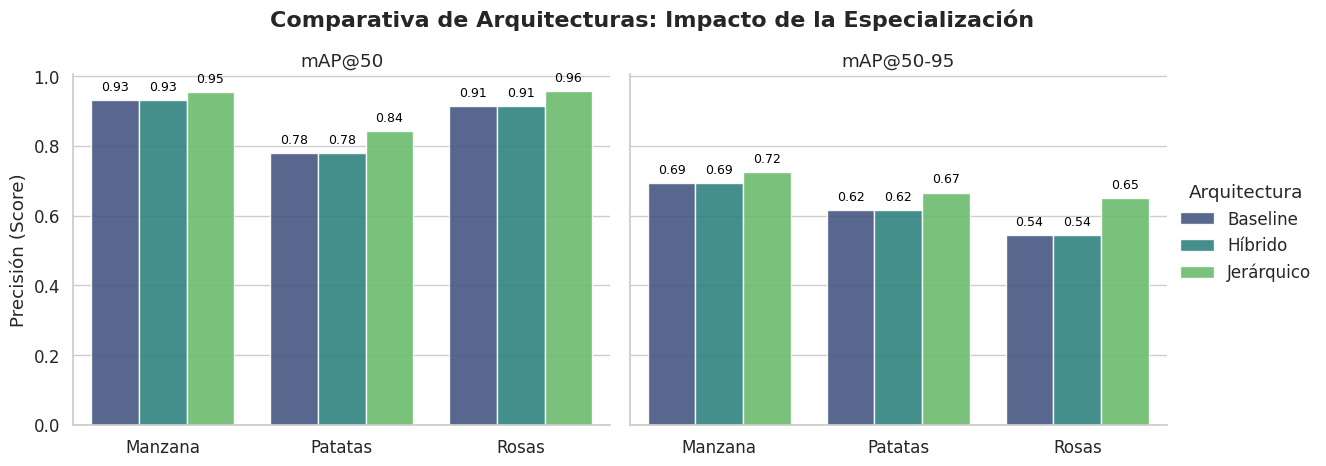

In [55]:
# -----------------------------------------------------------------------------
# 2. VISUALIZACIÓN COMPARATIVA
# -----------------------------------------------------------------------------

sns.set_theme(style="whitegrid", font_scale=1.1)

# Crear gráfico de barras agrupadas
g = sns.catplot(
    data=df_final,
    kind="bar",
    x="Especie",
    y="Score",
    hue="Arquitectura",
    col="Métrica",
    palette="viridis",
    height=5,
    aspect=1.2,
    alpha=0.9
)

# Ajustes visuales
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Comparativa de Arquitecturas: Impacto de la Especialización', fontsize=16, fontweight='bold')
g.set_axis_labels("", "Precisión (Score)")
g.set_titles("{col_name}")

# Añadir valores numéricos sobre las barras
for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points',
                        fontsize=9, color='black')

# Guardar en alta resolución
plt.savefig('comparativa_final_arquitecturas.png', dpi=300, bbox_inches='tight')
print("📸 Gráfica guardada como 'comparativa_final_arquitecturas.png'")
plt.show()

## Análisis de Mejora Relativa (Ganancia %)


In [56]:
# -----------------------------------------------------------------------------
# 3. CÁLCULO DE GANANCIA RELATIVA (DELTA)
# -----------------------------------------------------------------------------

print("\n--- ANÁLISIS DE MEJORA RELATIVA (Jerárquico vs Baseline) ---")
print("¿Cuánto mejora nuestra propuesta respecto al estándar?")

especies = df_final['Especie'].unique()
metricas = ['mAP@50', 'mAP@50-95']

for esp in especies:
    print(f"\n>> {esp.upper()}:")
    for met in metricas:
        # Filtrar valores
        base = df_final[(df_final['Especie']==esp) & (df_final['Arquitectura']=='Baseline') & (df_final['Métrica']==met)]['Score'].values[0]
        prop = df_final[(df_final['Especie']==esp) & (df_final['Arquitectura']=='Jerárquico') & (df_final['Métrica']==met)]['Score'].values[0]

        # Calcular Delta
        delta = prop - base
        perc = (delta / base) * 100

        simbolo = "+" if delta > 0 else ""
        print(f"   {met}: {base:.4f} -> {prop:.4f} | Dif: {simbolo}{delta:.4f} ({simbolo}{perc:.1f}%)")


--- ANÁLISIS DE MEJORA RELATIVA (Jerárquico vs Baseline) ---
¿Cuánto mejora nuestra propuesta respecto al estándar?

>> MANZANA:
   mAP@50: 0.9302 -> 0.9530 | Dif: +0.0228 (+2.5%)
   mAP@50-95: 0.6932 -> 0.7250 | Dif: +0.0318 (+4.6%)

>> PATATAS:
   mAP@50: 0.7780 -> 0.8411 | Dif: +0.0631 (+8.1%)
   mAP@50-95: 0.6153 -> 0.6654 | Dif: +0.0501 (+8.1%)

>> ROSAS:
   mAP@50: 0.9144 -> 0.9569 | Dif: +0.0425 (+4.6%)
   mAP@50-95: 0.5445 -> 0.6490 | Dif: +0.1045 (+19.2%)


# Conclusiones Generales y Trabajo Futuro


El presente estudio ha abordado la problemática de la detección de enfermedades vegetales en escenarios multi-cultivo, desafiando el paradigma convencional de los detectores monolíticos (*End-to-End*). A través de una validación experimental exhaustiva sobre un dataset heterogéneo de Manzana, Patata y Rosa, se han alcanzado las siguientes conclusiones científicas:

## La Especialización Supera a la Generalización


La evidencia empírica confirma la hipótesis central del trabajo: la arquitectura jerárquica (V1) supera consistentemente al enfoque global (V2).
*   **Ganancia en Detección:** En subdominios visualmente complejos y con menos datos, como el cultivo de Patata, la especialización incrementó el **mAP@50 en un +6.3%** (de 0.778 a 0.841). Esto demuestra que aislar el espacio de características permite al modelo converger mejor incluso en escenarios de *Small Data*.
*   **Ganancia en Localización:** El hallazgo más significativo reside en la métrica **mAP@50-95**. En el caso de las Rosas, el modelo especialista mejoró la calidad de las cajas delimitadoras en **+10 puntos porcentuales** (0.54 vs 0.65). Esto indica que el modelo global, saturado por la necesidad de aprender múltiples morfologías foliares, pierde la capacidad de definir con exactitud los bordes difusos de las lesiones.

## Ineficacia del Enmascaramiento Lógico (Experimento Híbrido)


El experimento con la arquitectura Híbrida (V3) arrojó resultados estadísticamente idénticos al Baseline. Este resultado negativo es de alto valor científico, pues permite concluir que **el error del modelo global es de representación, no de decisión**.
La red neuronal "comparte" neuronas para aprender texturas de patata y rosa, lo que provoca una **interferencia negativa (*Negative Transfer*)** en las capas profundas (Backbone). Filtrar las salidas al final no corrige el hecho de que el extractor de características no ha aprendido correctamente los patrones específicos de cada enfermedad. Por tanto, el entrenamiento separado es indispensable.

## Viabilidad del Enrutamiento Taxonómico

La primera etapa del pipeline, basada en **MobileNetV3**, demostró una robustez excepcional con una tasa de acierto superior al **99%**.
*   El coste computacional de esta etapa es marginal (<10ms) comparado con la ganancia de precisión en la etapa de detección.
*   Los escasos errores de clasificación (principalmente Rosas confundidas con Manzanas) son biológicamente coherentes y tienen un impacto despreciable en el rendimiento global del sistema.

## Calidad y Heterogeneidad de los Datos


El análisis reveló que el dataset de **Patatas** es el más desafiante debido a la alta densidad de lesiones y la similitud visual entre el fondo y la enfermedad (*Early Blight*). A pesar de ello, la arquitectura jerárquica logró extraer el máximo rendimiento posible, validando la robustez del método frente a datasets desbalanceados.

## Trabajo Futuro



A la luz de los resultados, se proponen las siguientes líneas de investigación para continuar el desarrollo:
1.  **Despliegue en Edge Computing:** Dado el bajo coste de MobileNet y la eficiencia de YOLOv8s, el siguiente paso lógico es la cuantización de los modelos a formato ONNX/TFLite para su implementación en una aplicación móvil Android/iOS que funcione sin conexión.
2.  **Mecanismos de Atención Visual:** Investigar la incorporación de módulos de atención (CBAM o SE-Blocks) en el backbone de YOLO para intentar mitigar la interferencia en el modelo global sin necesidad de separar los entrenamientos.
3.  **Few-Shot Learning:** Para cultivos como la patata, donde la recolección de datos es costosa, explorar técnicas de *Data Augmentation* generativo (GANs) para enriquecer sintéticamente el dataset de entrenamiento.
